In [1]:
library(ggplot2)
library(forecast)
library(gridExtra)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
# Load the data
cocoa_data <- read.csv("CocoaPrice.csv")

In [3]:
print(cocoa_data)

          Date   Price
1   1994-10-01 1447.95
2   1994-11-01 1437.05
3   1994-12-01 1399.43
4   1995-01-01 1468.86
5   1995-02-01 1510.55
6   1995-03-01 1484.91
7   1995-04-01 1469.26
8   1995-05-01 1445.32
9   1995-06-01 1437.14
10  1995-07-01 1364.10
11  1995-08-01 1413.00
12  1995-09-01 1396.86
13  1995-10-01 1394.50
14  1995-11-01 1436.50
15  1995-12-01 1378.84
16  1996-01-01 1349.50
17  1996-02-01 1369.81
18  1996-03-01 1338.62
19  1996-04-01 1456.24
20  1996-05-01 1524.09
21  1996-06-01 1537.60
22  1996-07-01 1495.70
23  1996-08-01 1499.86
24  1996-09-01 1476.14
25  1996-10-01 1477.04
26  1996-11-01 1469.33
27  1996-12-01 1474.30
28  1997-01-01 1428.45
29  1997-02-01 1372.70
30  1997-03-01 1523.60
31  1997-04-01 1571.05
32  1997-05-01 1568.29
33  1997-06-01 1688.38
34  1997-07-01 1677.30
35  1997-08-01 1652.14
36  1997-09-01 1769.64
37  1997-10-01 1741.43
38  1997-11-01 1694.80
39  1997-12-01 1737.29
40  1998-01-01 1668.10
41  1998-02-01 1640.85
42  1998-03-01 1719.18
43  1998-04

In [4]:
summary(cocoa_data)

     Date               Price       
 Length:354         Min.   : 874.1  
 Class :character   1st Qu.:1396.1  
 Mode  :character   Median :1806.0  
                    Mean   :1853.0  
                    3rd Qu.:2168.5  
                    Max.   :6510.2  

In [5]:
# Convert the 'Date' column to a Date object
cocoa_data$Date <- as.Date(cocoa_data$Date)

VISUALIZATIONS

In [6]:
dev.off()  # Close all open graphics devices
graphics.par <- par(no.readonly = TRUE)  # Save default parameters
par(graphics.par)

null device 
          1

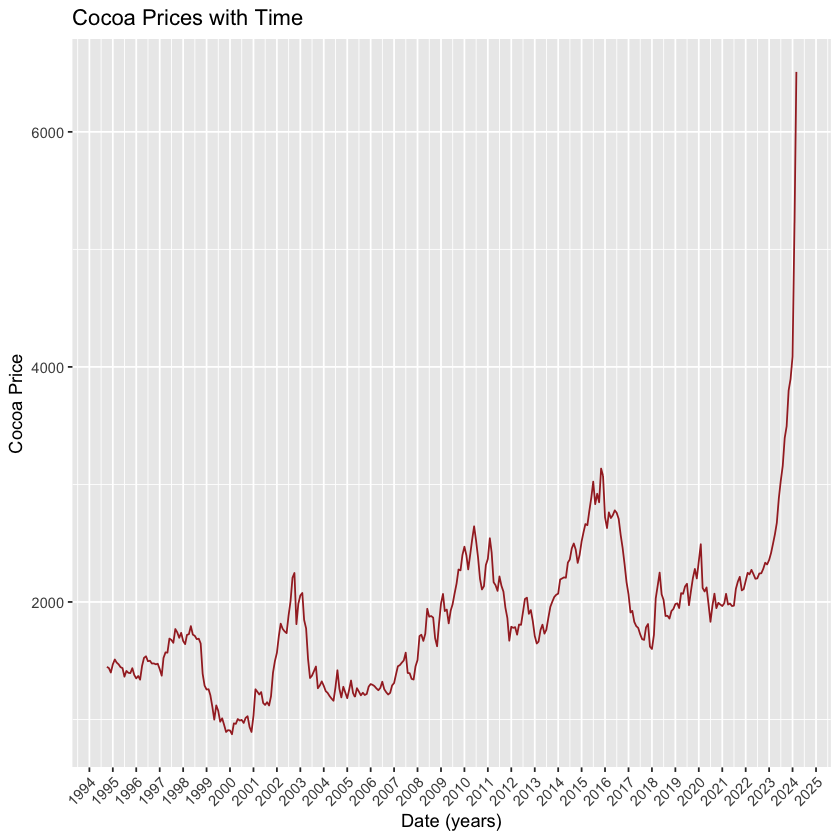

In [7]:
# Plot the time series with breaks for each year
cocoa_plot <- ggplot(data = cocoa_data, aes(x = Date, y = Price)) +
  geom_line(color = 'brown') +
  scale_x_date(date_breaks = "1 year", date_labels = "%Y") + 
  labs(x = "Date (years)", y = "Cocoa Price", title = "Cocoa Prices with Time") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

cocoa_plot

## REGRESSION

LINEAR MODEL

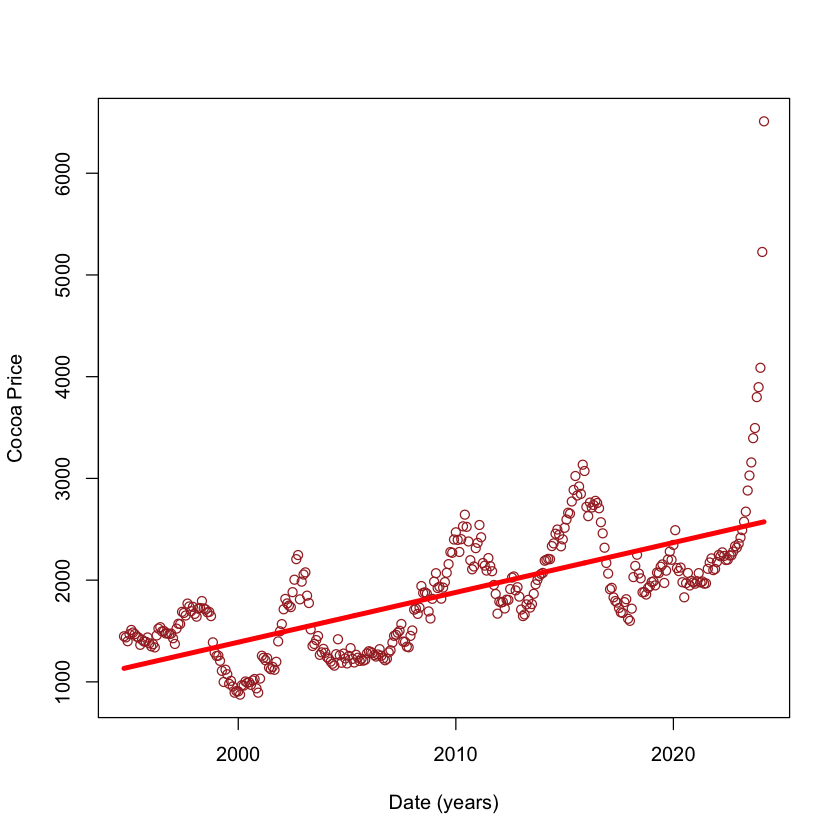

In [8]:
# Fit a linear regression model
cocoa_lm <- lm(Price ~ time(format(Date, "%Y")), data = cocoa_data)

plot(cocoa_data$Date, cocoa_data$Price, col = 'brown', xlab = "Date (years)", ylab = "Cocoa Price", bg='white')

# Generate predictions from the linear regression model
x <- cocoa_data$Date
y <- predict(cocoa_lm)

# Add the regression line to the plot
lines(x, y, col = 'red', lwd = 4)

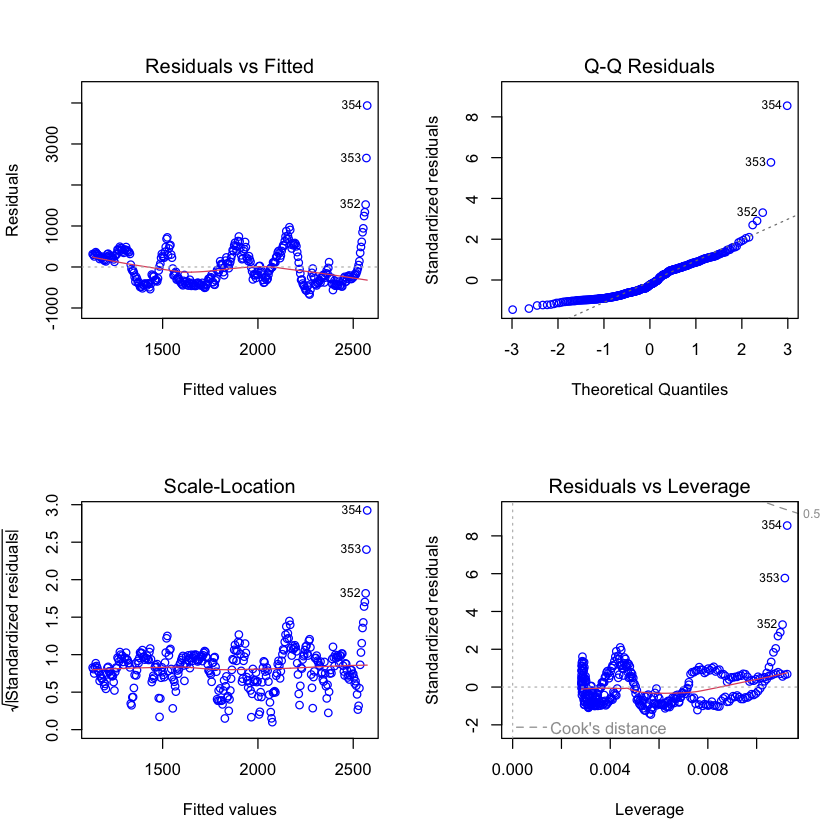

In [9]:
par(mfrow=c(2,2))
plot(cocoa_lm, col='blue')

Logarithmic Model

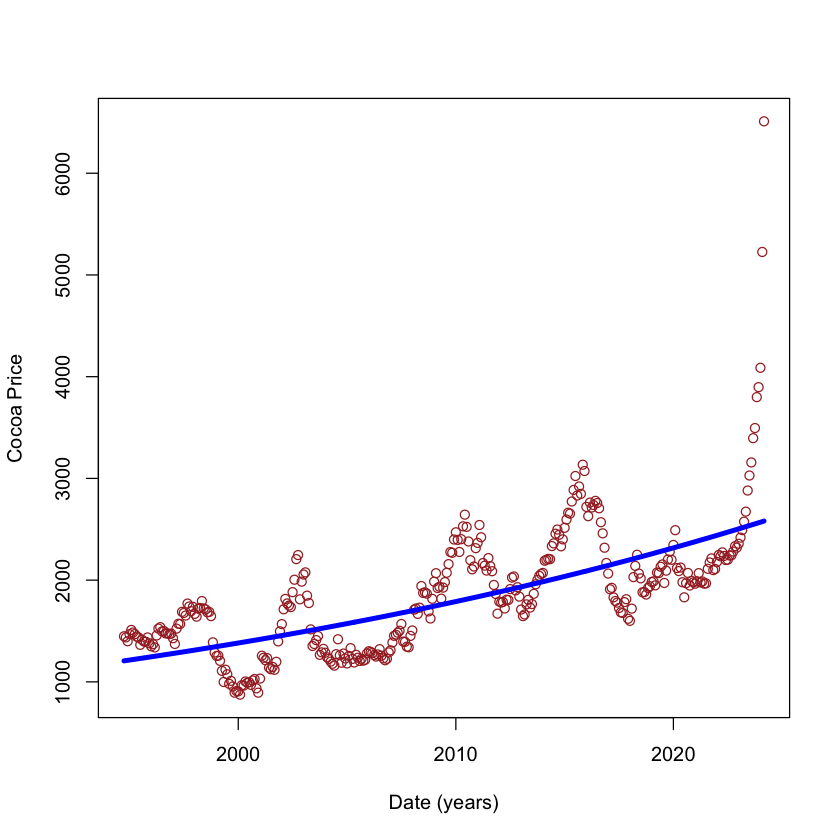

In [10]:
# Fit a linear regression model with log-transformed cocoa prices
cocoa_lm_log <- lm(log(Price) ~ time(format(Date, "%Y")), data = cocoa_data)

# Plot the data points
plot(cocoa_data$Date, cocoa_data$Price, col = 'brown', xlab = "Date (years)", ylab = "Cocoa Price")

# Generate predictions from the linear regression model
x <- cocoa_data$Date
y <- exp(predict(cocoa_lm_log))

# Add the regression line to the plot
lines(x, y, col = 'blue', lwd = 4)

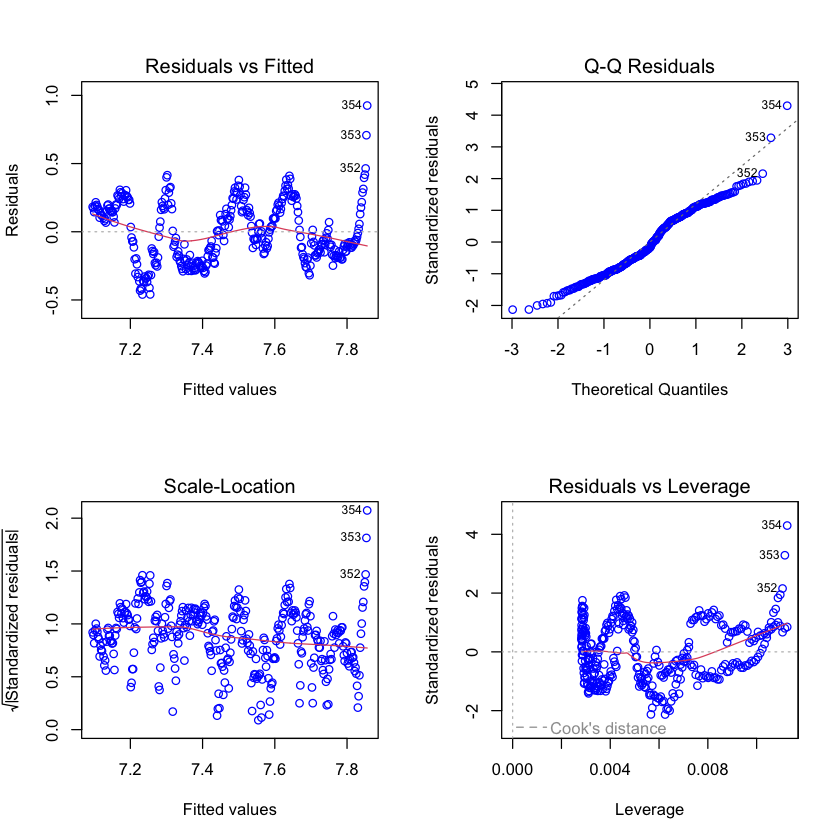

In [11]:
par(mfrow=c(2,2))
plot(cocoa_lm_log, col='blue')

## MOVING AVERAGES

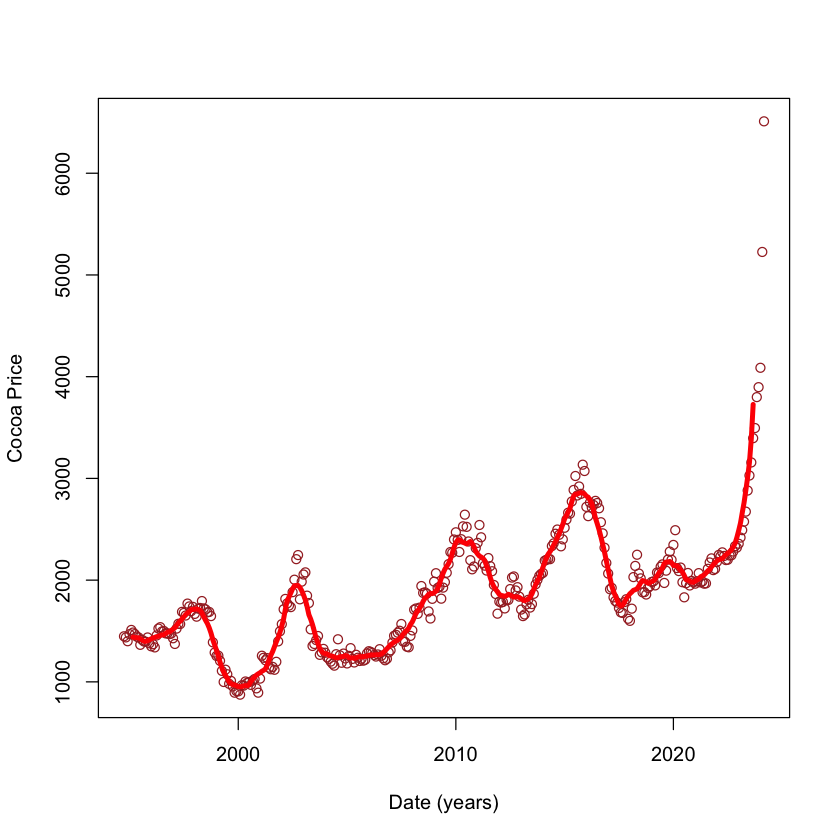

In [12]:
# Calculate the moving average with a window size of 12 months
trend <- zoo::rollmean(cocoa_data$Price, 12, na.pad = TRUE)

trend <- round(trend, 2)

# Plot the cocoa prices
plot(cocoa_data$Date, cocoa_data$Price, col = 'brown', xlab = "Date (years)", ylab = "Cocoa Price")

x <- cocoa_data$Date

lines(x, trend, col = 'red', lw = 4)

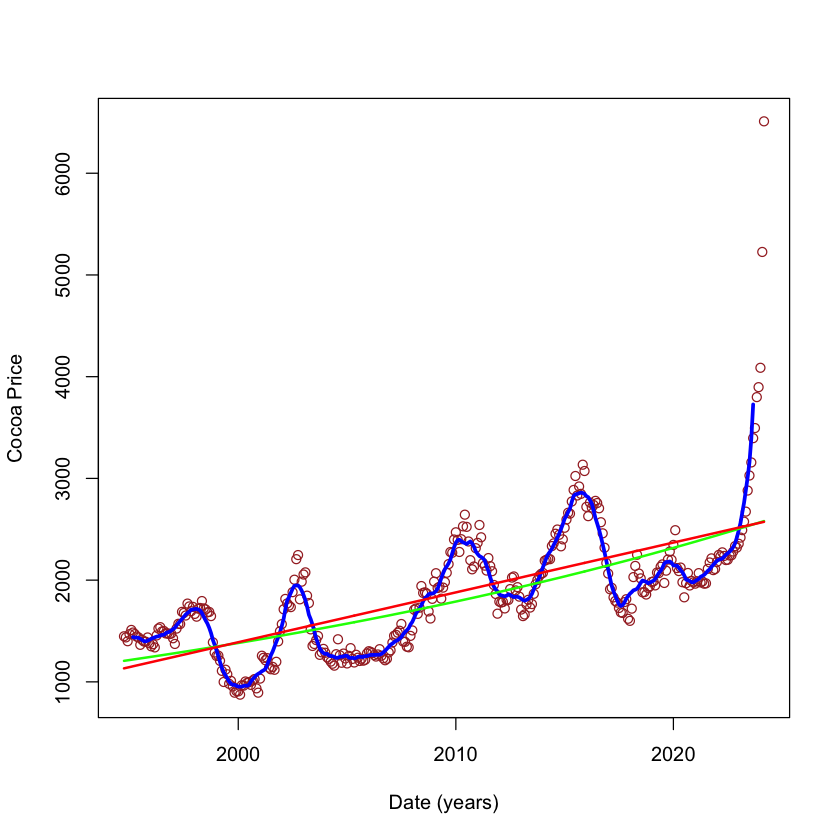

In [13]:
# Plot the cocoa prices with blue points
plot(cocoa_data$Date, cocoa_data$Price, col = 'brown', xlab = "Date (years)", ylab = "Cocoa Price")
x <- cocoa_data$Date

# Plot the moving average trend line
lines(x, trend, col = 'blue', lw = 3)

# predictions from the linear regression model with log-transformed prices
y <- exp(predict(cocoa_lm_log))

# Plot the predictions in red
lines(x, y, col = 'green', lw = 2)

# Generate predictions from the linear regression model with original prices
y <- predict(cocoa_lm)

# Plot the predictions in dark green
lines(x, y, col = 'red', lw = 2)

## ADDITIVE DECOMPOSITION

TREND

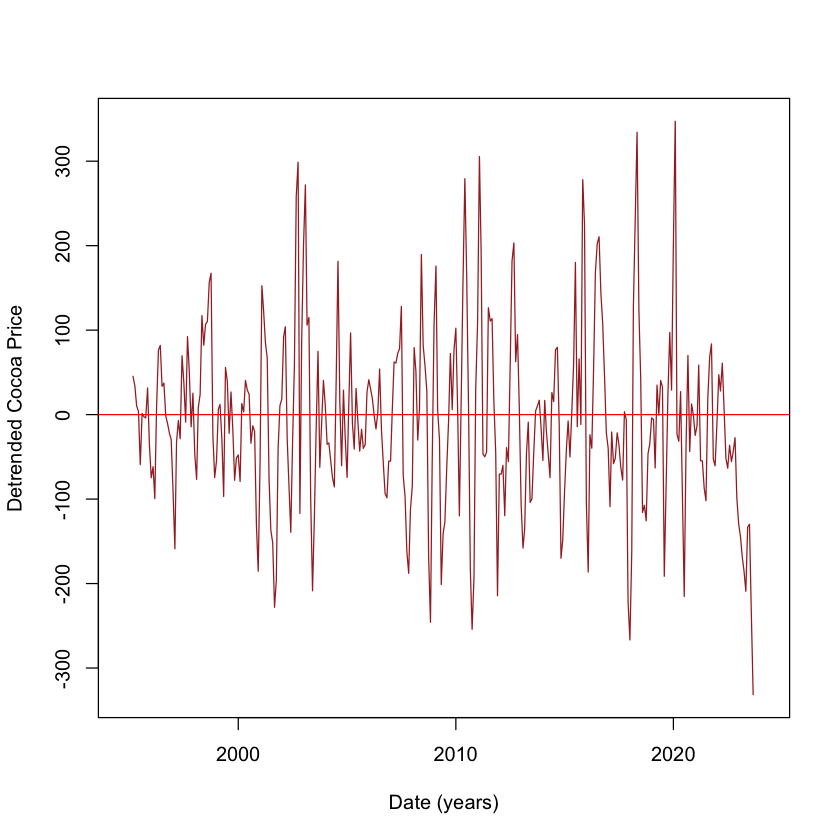

In [14]:
# Calculate the moving average trend with a window size of 12 months
trend <- zoo::rollmean(cocoa_data$Price, 12, na.pad = TRUE)

# Calculate the detrended cocoa prices
detrended <- cocoa_data$Price - trend

# Round the detrended values to two decimal places
detrended <- round(detrended, 2)

# Plot the detrended cocoa prices with lines instead of points
plot(cocoa_data$Date, detrended, type = "l", xlab = "Date (years)", ylab = "Detrended Cocoa Price", col='brown')

# Add a horizontal line at y = 0
abline(h = 0, col = 'red')


ADDITIVE SEASONALITY

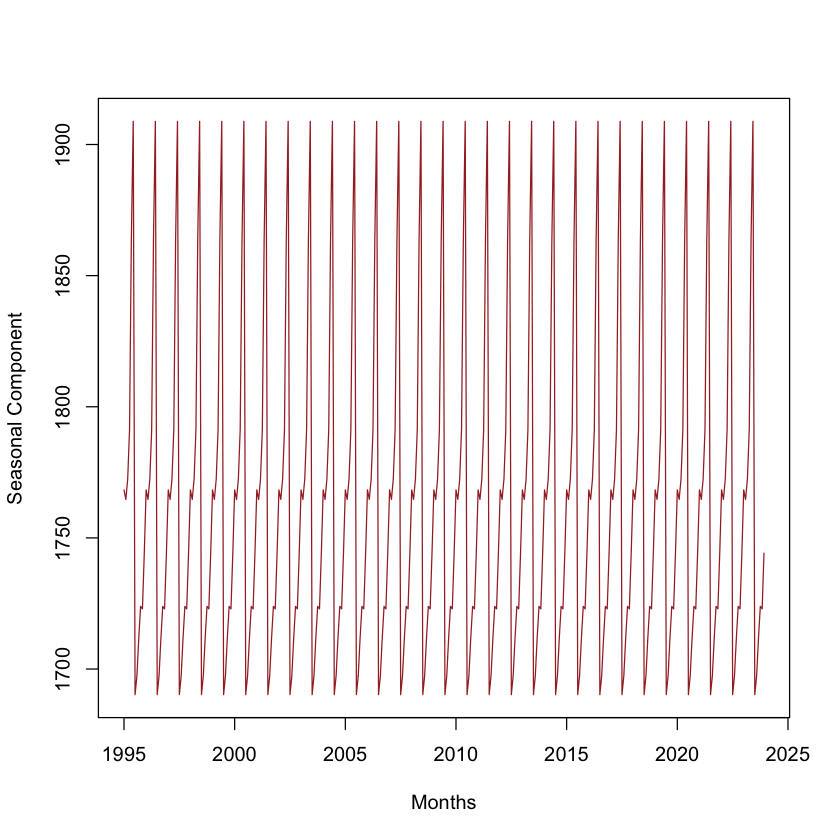

In [15]:
# Define a function to calculate the arithmetic monthly mean
arith_monthly_mean <- function(d) {
    s <- rep(0, 12)
    for (month in 1:12) {
        s[month] <- sum(d$Price[seq(month, length(d$Price), by = 12)])
    }
    s <- s / length(unique(format(cocoa_data$Date, "%Y")))
    return(s)
}

# Calculate the seasonal component
seasonal_values <- arith_monthly_mean(cocoa_data)
seasonal <- ts(rep(seasonal_values, length(cocoa_data$Date) / 12), start = c(1995, 1), frequency = 12)

# Round the seasonal component values to two decimal places
seasonal <- round(seasonal, 2)

# Plot the seasonal component
plot(seasonal, xlab = "Months", ylab = "Seasonal Component", col='brown')

# Add a horizontal line at y = 0
abline(h = 0, col = 'red')



ADDITIVE REMAINDER

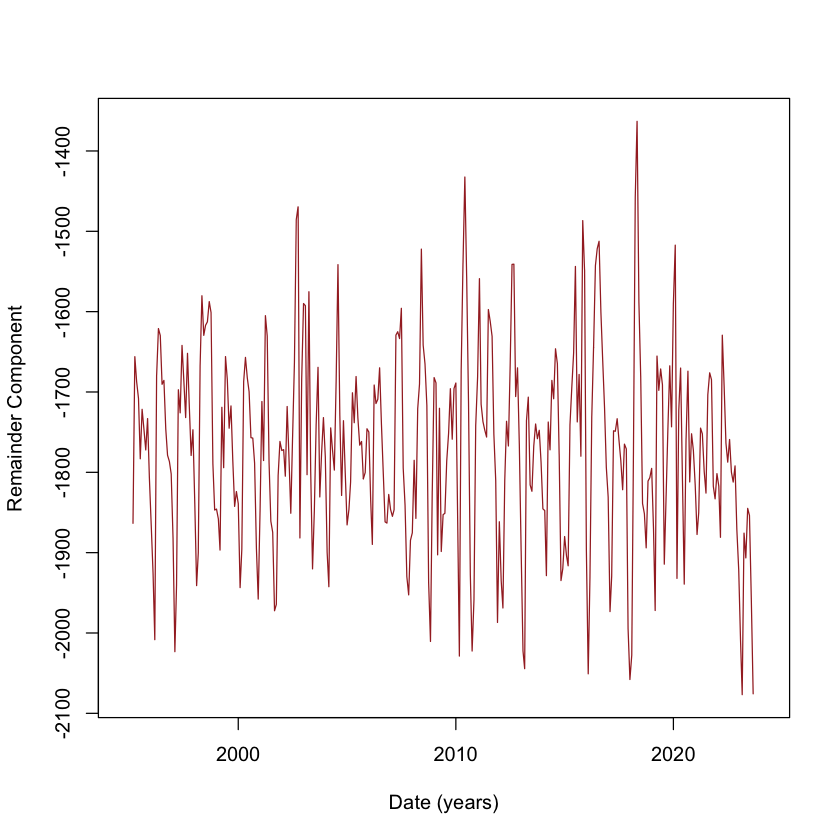

In [16]:
# Calculate the detrended cocoa prices
detrended <- cocoa_data$Price - trend

# Truncate or pad the seasonal component to match the length of the detrended component
seasonal_matched <- seasonal[1:length(detrended)]

# Calculate the remainder component by subtracting the seasonal component from the detrended prices
remainder <- detrended - seasonal_matched

# Round the remainder component values to two decimal places
remainder <- round(remainder, 2)

# Plot the remainder component against the date
plot(cocoa_data$Date, remainder, type = "l", xlab = "Date (years)", col = 'brown', ylab = "Remainder Component")

# Add a horizontal line at y = 0
abline(h = 0, col = 'red')


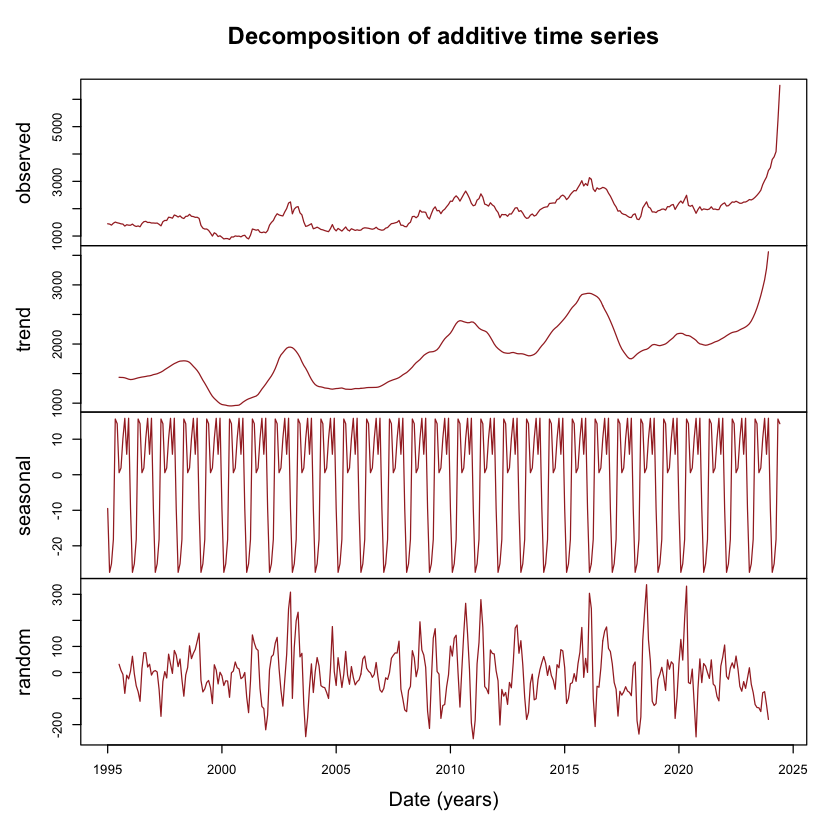

In [17]:
ts_data <- ts(cocoa_data$Price,start = c(1995, 1),  frequency = 12) 

# Perform additive decomposition
decomposed_data <- decompose(ts_data, type = "additive")

# Plot the decomposed components
plot(decomposed_data, col='brown', xlab='Date (years)')

## Multiplicative Decomposition

TREND

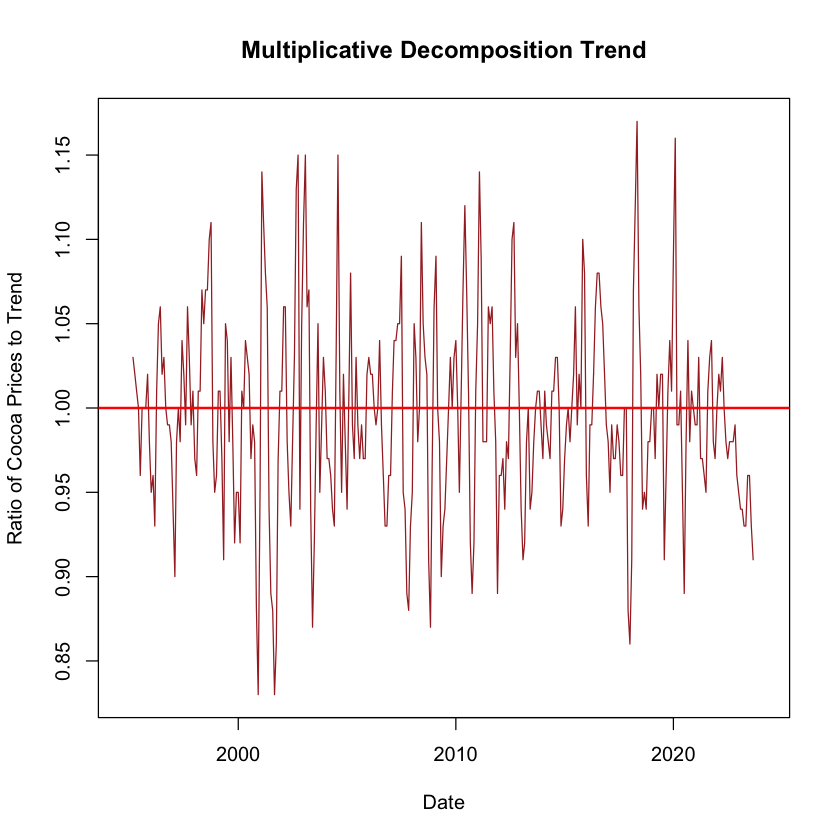

In [18]:
# ratio of cocoa prices to the trend
mult_detrended <- cocoa_data$Price / trend

mult_detrended <- round(mult_detrended, 2)

# Plot the ratio of cocoa prices to the trend
plot(cocoa_data$Date, mult_detrended, type = "l", xlab = "Date", col='brown', ylab = "Ratio of Cocoa Prices to Trend", 
    main='Multiplicative Decomposition Trend')

# Add a horizontal line at y = 1
abline(h = 1, col = 'red', lw=2)

Multiplicative Seasonality

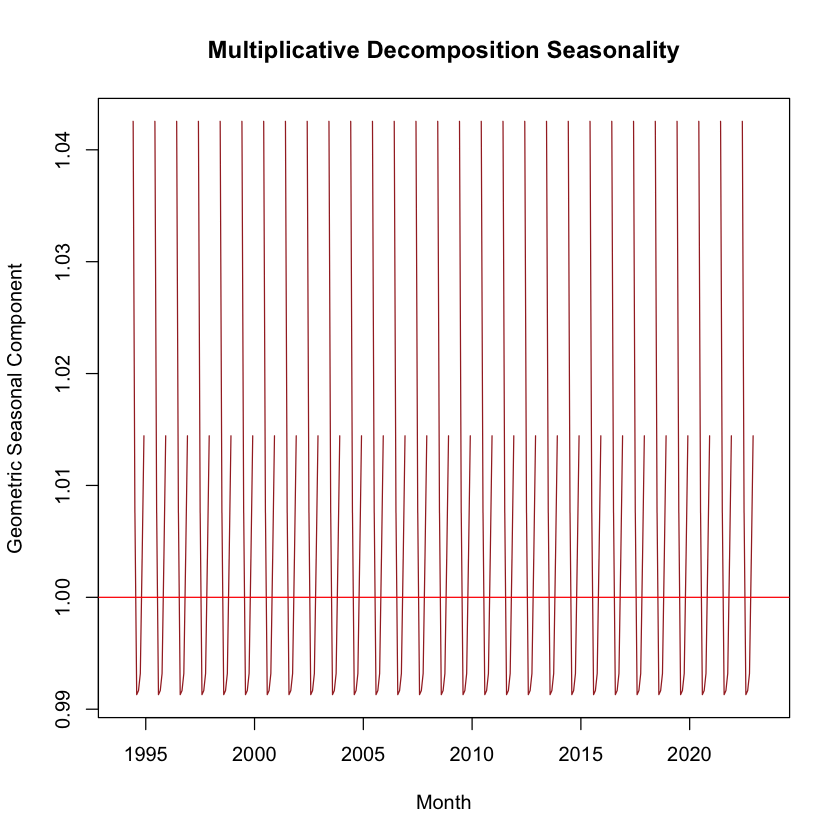

In [19]:
# Define a function to calculate the geometric monthly mean
geom_monthly_mean <- function(d) {
    s <- rep(1, 12)
    for (month in 1:12) {
        for (year in 0:10) {
            s[month] <- s[month] * d[(year * 12) + month]
        }
    }
    for (month in 1:6) {
        for (year in 1:11) {
            s[month] <- s[month] * d[(year * 12) + month]
        }
    }
    s <- s^(1/11)
    return(s)
}

# Calculate the geometric seasonal component
mult_seasonal_values <- geom_monthly_mean(mult_detrended)
seasonal_length <- length(cocoa_data$Date)
mult_seasonal <- ts(rep(mult_seasonal_values, length.out = seasonal_length), start = c(1994, 1), frequency = 12)

# Plot the geometric seasonal component
plot(mult_seasonal, xlab = "Month", ylab = "Geometric Seasonal Component", col='brown',
    main='Multiplicative Decomposition Seasonality')

# Add a horizontal line at y = 1
abline(h = 1, col = 'red')


Multiplicative Remainder

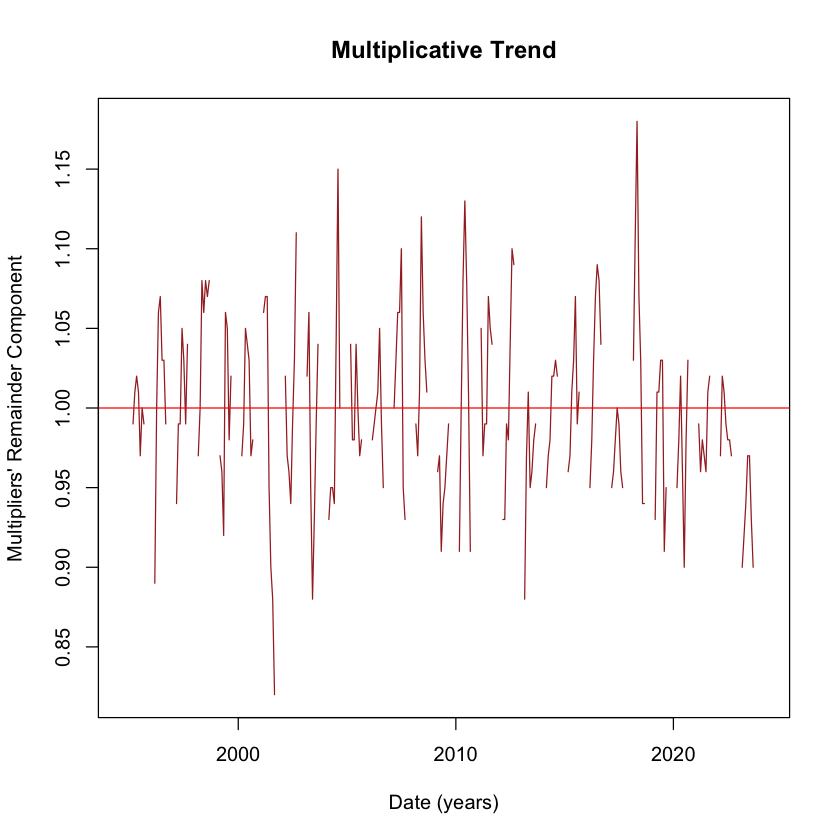

In [20]:
# multipliers' remainder component
mult_remainder <- mult_detrended / mult_seasonal

mult_remainder <- round(mult_remainder, 2)

plot(cocoa_data$Date, mult_remainder, type = "l", xlab = "Date (years)", ylab = "Multipliers' Remainder Component", col='brown',
    main='Multiplicative Trend')

# Add a horizontal line at y = 1
abline(h = 1, col = 'red')

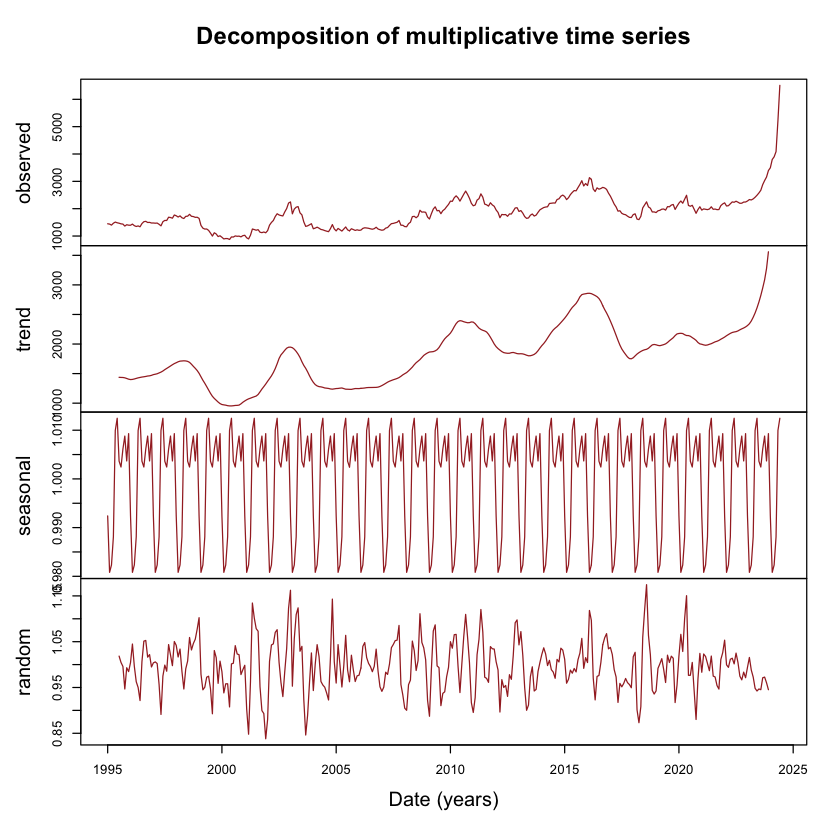

In [21]:
ts_data <- ts(cocoa_data$Price,start = c(1995, 1),  frequency = 12) 

decomposed_data <- decompose(ts_data, type = "multiplicative")

plot(decomposed_data, col='brown', xlab='Date (years)')

## Seasonal Decomposition using STL

Additive (Default) STL Decomposition

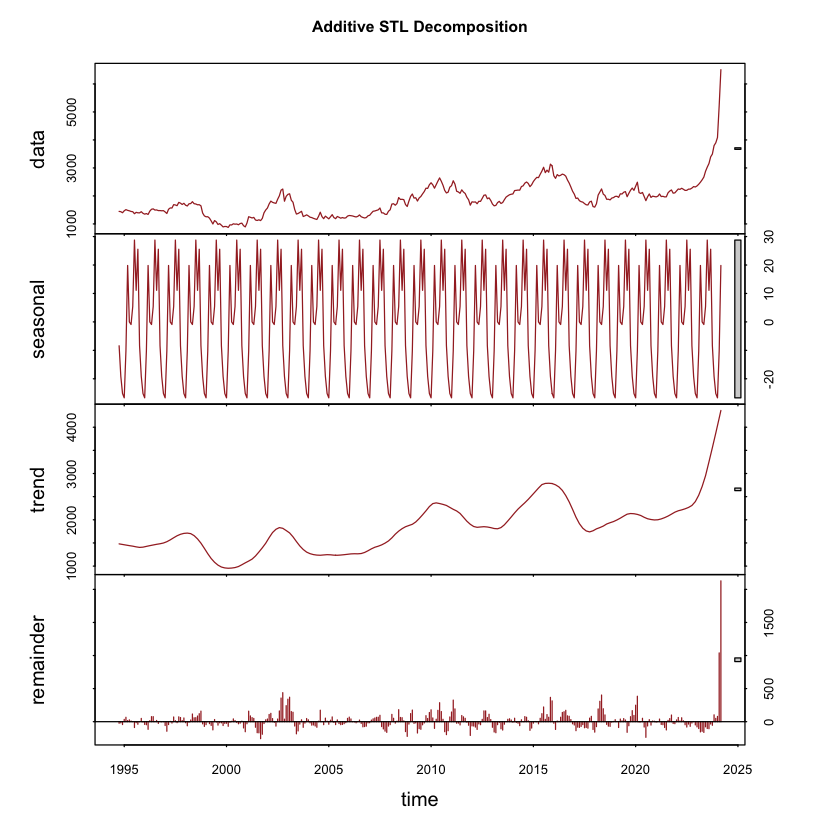

In [22]:
# Convert cocoa_data to a time series object with monthly frequency
ts_cocoa <- ts(cocoa_data$Price, start = c(1994, 10), frequency = 12)

# Create training and test sets
train <- window(ts_cocoa, end = c(2023, 9))
test <- window(ts_cocoa, start = c(2023, 10))

fit.stl <- stl(ts_cocoa, s.window="period", robust=TRUE)    
plot(fit.stl, col='brown', main='Additive STL Decomposition')

In [23]:
summary(fit.stl$time.series)

    seasonal            trend          remainder       
 Min.   :-26.6995   Min.   : 953.6   Min.   :-256.373  
 1st Qu.:-19.1644   1st Qu.:1429.9   1st Qu.: -51.031  
 Median : -0.9182   Median :1817.9   Median :  -2.258  
 Mean   : -0.1975   Mean   :1837.4   Mean   :  15.830  
 3rd Qu.: 11.1055   3rd Qu.:2132.8   3rd Qu.:  53.401  
 Max.   : 28.7684   Max.   :4361.6   Max.   :2128.698  

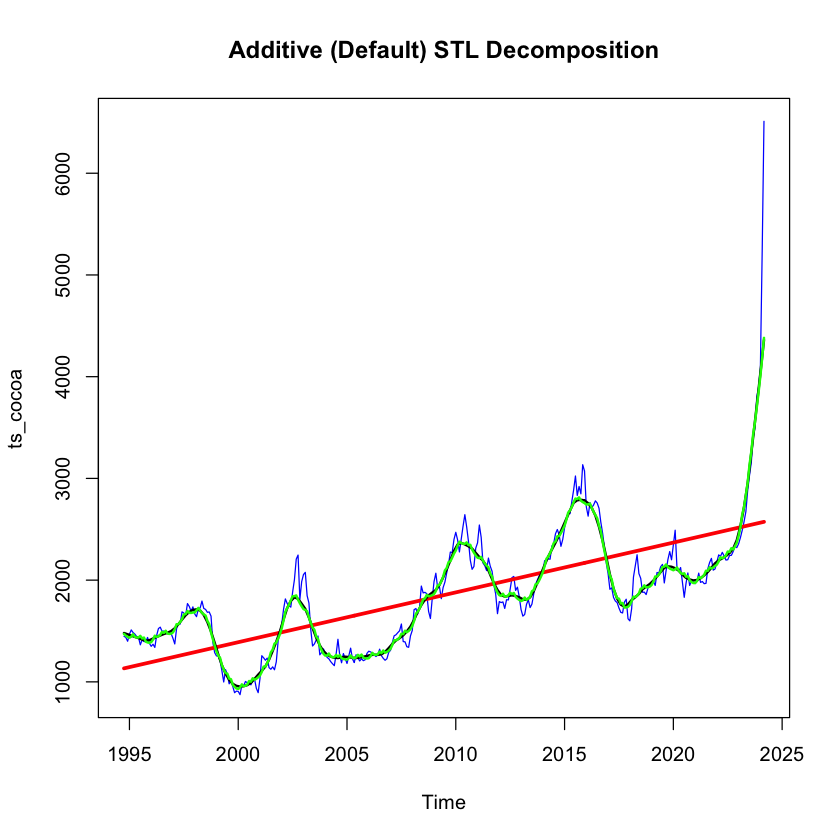

In [24]:
S <- fit.stl$time.series[,'seasonal']
T <- fit.stl$time.series[,'trend']
R <- fit.stl$time.series[,'remainder']

plot(ts_cocoa, col='blue', main='Additive (Default) STL Decomposition', )
x <- as.vector(time(ts_cocoa))
y <- predict.lm(cocoa_lm)
lines(x, y, col='red', lw=3)
y <- T
lines(x, y, col='black', lw=2)
y <- T+S
lines(x, y, col='green', lw=2)

Multiplicative STL Decomposition

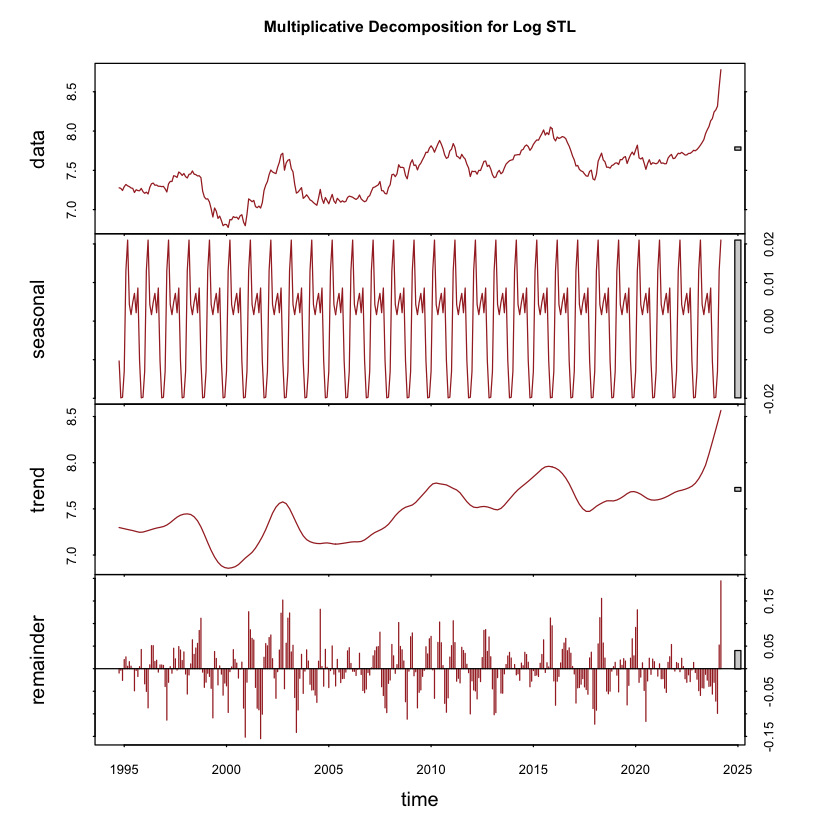

In [25]:
fit.mult.stl <- stl(log(ts_cocoa), s.window="period")
plot(fit.mult.stl, col='brown', main='Multiplicative Decomposition for Log STL')

In [26]:
summary(exp(fit.mult.stl$time.series))

    seasonal          trend          remainder     
 Min.   :0.9803   Min.   : 950.4   Min.   :0.8565  
 1st Qu.:0.9871   1st Qu.:1422.7   1st Qu.:0.9662  
 Median :1.0022   Median :1836.5   Median :0.9966  
 Mean   :1.0000   Mean   :1849.8   Mean   :1.0001  
 3rd Qu.:1.0083   3rd Qu.:2149.6   3rd Qu.:1.0320  
 Max.   :1.0212   Max.   :5247.9   Max.   :1.2147  

In [27]:
exp(fit.mult.stl$time.series[,'seasonal'])

Jan       Feb       Mar       Apr       May       Jun       Jul      
1994                                                                      
1995 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
1996 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
1997 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
1998 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
1999 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2000 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2001 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2002 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2003 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2004 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2005 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2006 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2007 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2008 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2009 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2010 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2011 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2012 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2013 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2014 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2015 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2016 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2017 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2018 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2019 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2020 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2021 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2022 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2023 0.9870565 1.0133052 1.0212235 1.0043091 1.0016702 1.0048776 1.0072171
2024 0.9870565 1.0133052 1.0212235                                        
     Aug       Sep       Oct       Nov       Dec      
1994                     0.9897146 0.9803099 0.9804575
1995 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
1996 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
1997 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
1998 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
1999 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2000 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2001 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2002 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2003 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2004 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2005 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2006 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2007 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2008 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2009 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2010 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2011 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2012 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2013 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2014 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2015 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2016 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2017 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2018 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2019 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2020 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2021 1.0021711 1.0086130 0.9897146 0.9803099 0.9804575
2022 1.002

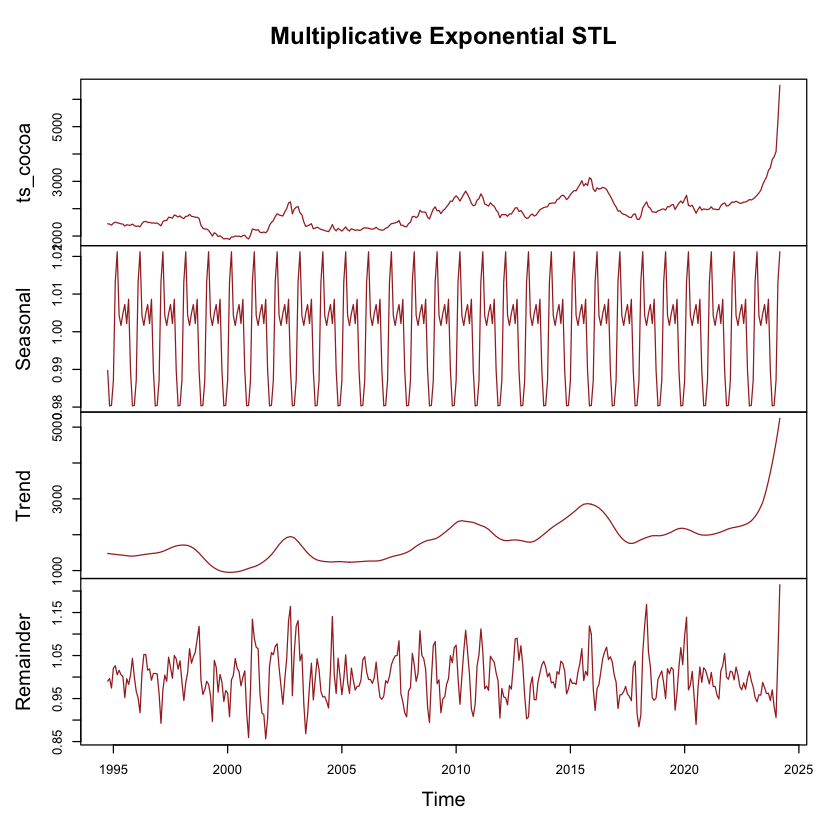

In [28]:
Seasonal <- exp(fit.mult.stl$time.series[,'seasonal'])
Trend <- exp(fit.mult.stl$time.series[,'trend'])
Remainder <- exp(fit.mult.stl$time.series[,'remainder'])

plot(cbind(ts_cocoa, Seasonal, Trend, Remainder), col = 'brown',
     main='Multiplicative Exponential STL')

Comparison of STL with multiplicative decomposition

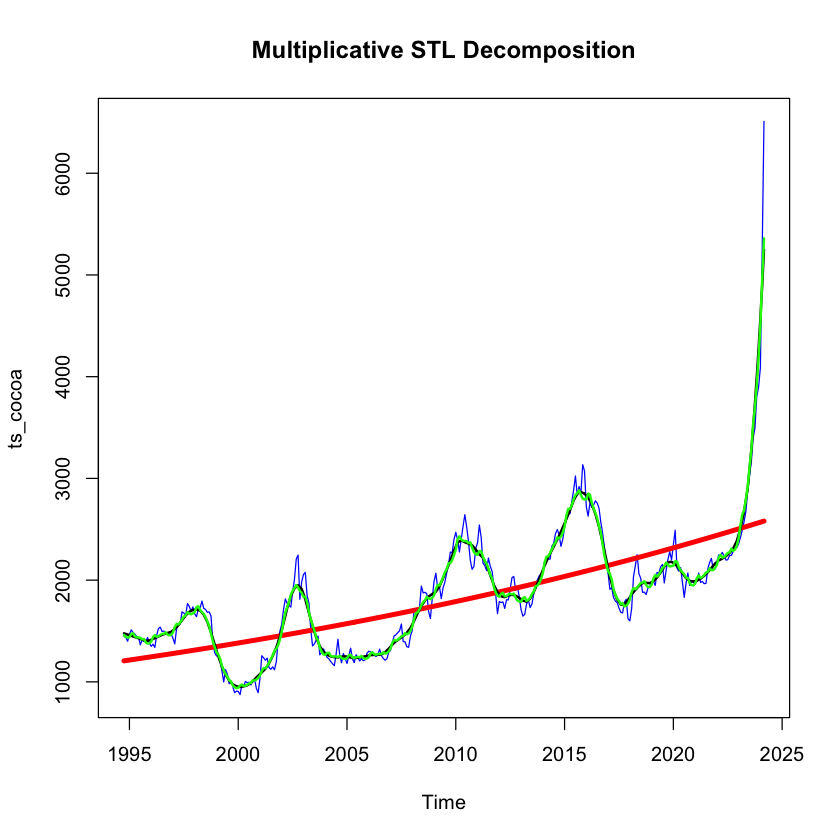

In [29]:
plot(ts_cocoa, col='blue', 
     main='Multiplicative STL Decomposition')
x <- as.vector(time(ts_cocoa))
y <- exp(predict.lm(cocoa_lm_log))
lines(x, y, col='red', lw=4)
y <- Trend
lines(x, y, col='black', lw=2)
y <- Seasonal * Trend
lines(x, y, col='green', lw=2)

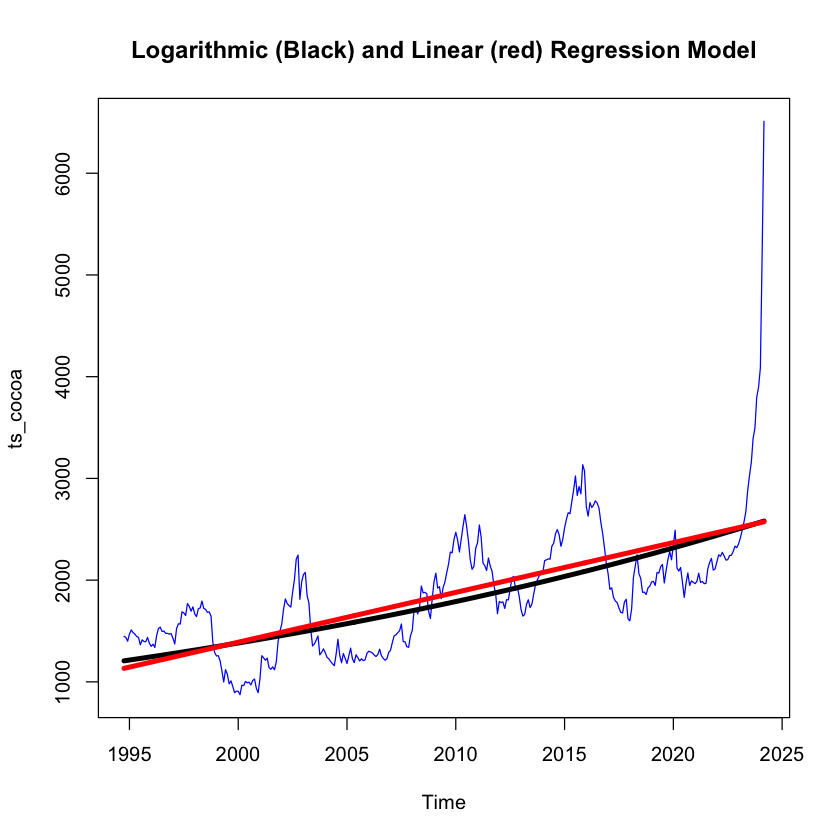

In [30]:
plot(ts_cocoa, col='blue', 
     main='Logarithmic (Black) and Linear (red) Regression Model')
x <- as.vector(time(ts_cocoa))
y <- exp(predict.lm(cocoa_lm_log))
lines(x, y, col='black', lw=4)
y <- predict.lm(cocoa_lm)
lines(x, y, col='red', lw=4)

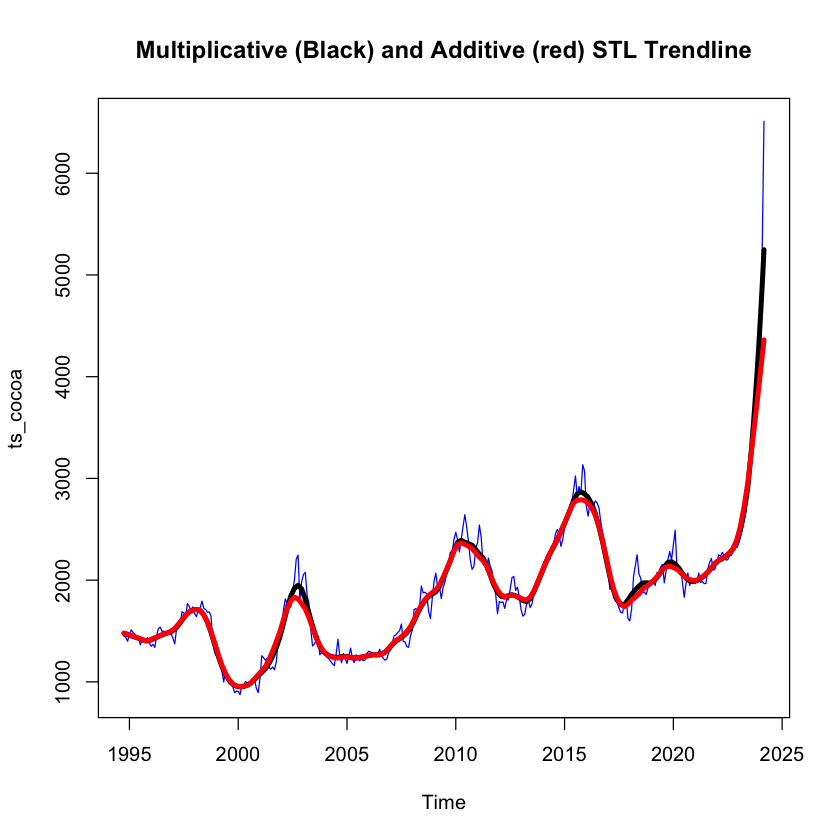

In [31]:
plot(ts_cocoa, col='blue', 
     main='Multiplicative (Black) and Additive (red) STL Trendline')
x <- as.vector(time(ts_cocoa))
y <- Trend
lines(x, y, col='black', lw=4)
y <- T
lines(x, y, col='red', lw=4)

# SIMPLE TIME SERIES MODELS

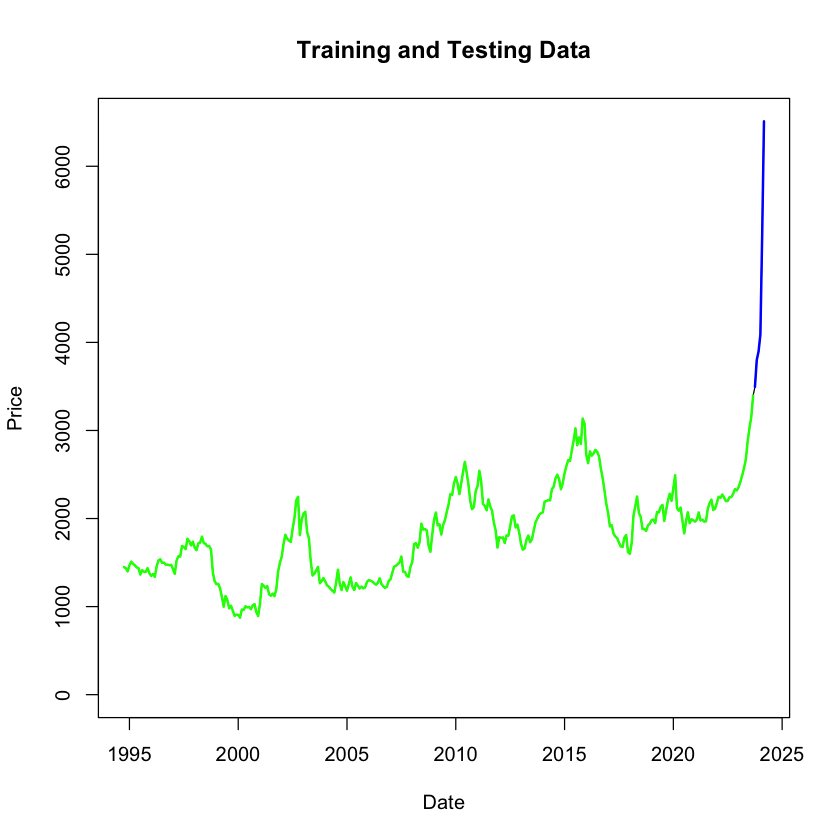

In [32]:
# Plot the entire time series
plot(ts_cocoa, ylim = c(0, max(ts_cocoa)), type = "l", col = "black", xlab = "Date", ylab = "Price", main = "Training and Testing Data")

# Overlay training set with blue line
lines(train, col = 'green', lwd = 2)

# Overlay test set with red line
lines(test, col = 'blue', lwd = 2)


Forecast Using the Mean Model

In [33]:
mean(train)

[1] 1807.319

In [34]:
fcast.mean <- meanf(train,h=length(test) + 50)
fcast.mean

         Point Forecast    Lo 80    Hi 80    Lo 95   Hi 95
Oct 2023       1807.319 1161.013 2453.625 817.3084 2797.33
Nov 2023       1807.319 1161.013 2453.625 817.3084 2797.33
Dec 2023       1807.319 1161.013 2453.625 817.3084 2797.33
Jan 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Feb 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Mar 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Apr 2024       1807.319 1161.013 2453.625 817.3084 2797.33
May 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Jun 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Jul 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Aug 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Sep 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Oct 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Nov 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Dec 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Jan 2025       1807.319 1161.013 2453.625 817.3084 2797.

In [35]:
meanf(train,h=length(test) +0)

         Point Forecast    Lo 80    Hi 80    Lo 95   Hi 95
Oct 2023       1807.319 1161.013 2453.625 817.3084 2797.33
Nov 2023       1807.319 1161.013 2453.625 817.3084 2797.33
Dec 2023       1807.319 1161.013 2453.625 817.3084 2797.33
Jan 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Feb 2024       1807.319 1161.013 2453.625 817.3084 2797.33
Mar 2024       1807.319 1161.013 2453.625 817.3084 2797.33

In [36]:
round(accuracy(fcast.mean, test),2)

ME      RMSE    MAE     MPE   MAPE  MASE ACF1 Theil's U
Training set    0.00  501.91  412.22 -8.43 25.43 1.39 0.97   NA     
Test set     2695.19 2892.14 2695.19 57.96 57.96 9.08 0.38 4.08

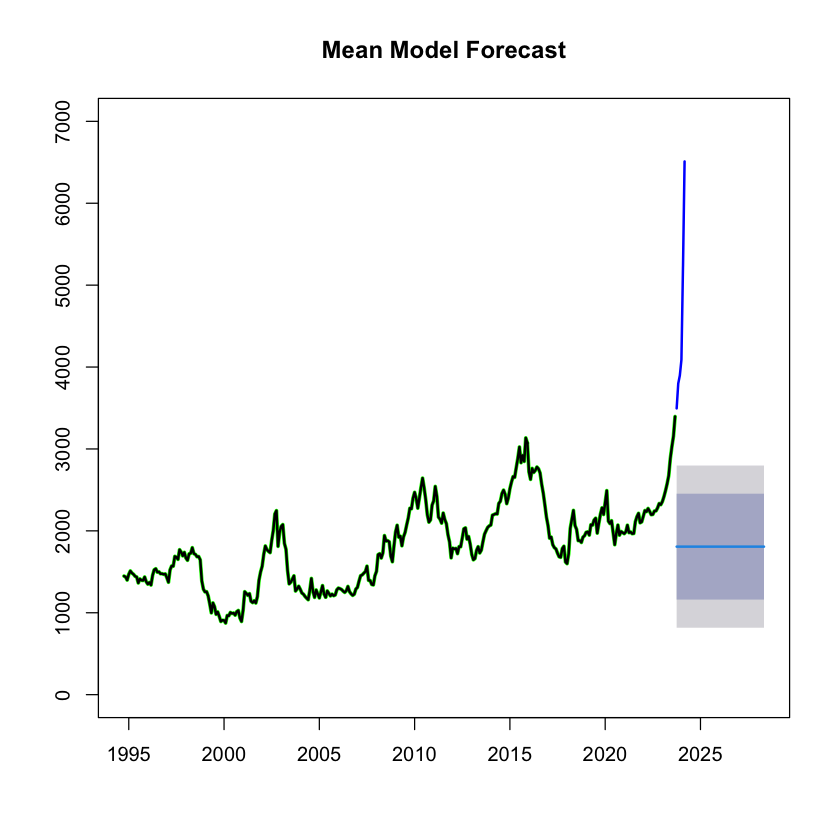

In [37]:
# Plot the forecast using meanf
plot(fcast.mean, col = 'green', lwd = 3, ylim = c(0, 7000),
     main = 'Mean Model Forecast')

# Plot the training set up to September 2023
train_up_to_sep <- window(train, end = c(2023, 9))

lines(train_up_to_sep, col = 'black', lwd = 2)

# Plot the test set
lines(test, col = 'blue', lwd = 2)

Forecast Using Naive Model

In [38]:
fcast.rw <- rwf(train, h=length(test))
fcast.rw

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023        3395.58 3268.858 3522.302 3201.776 3589.384
Nov 2023        3395.58 3216.368 3574.792 3121.500 3669.660
Dec 2023        3395.58 3176.092 3615.068 3059.901 3731.259
Jan 2024        3395.58 3142.137 3649.023 3007.972 3783.188
Feb 2024        3395.58 3112.222 3678.938 2962.221 3828.939
Mar 2024        3395.58 3085.176 3705.984 2920.859 3870.301

In [39]:
fcast.naive <- naive(train,h=30)
fcast.naive

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023        3395.58 3268.858 3522.302 3201.776 3589.384
Nov 2023        3395.58 3216.368 3574.792 3121.500 3669.660
Dec 2023        3395.58 3176.092 3615.068 3059.901 3731.259
Jan 2024        3395.58 3142.137 3649.023 3007.972 3783.188
Feb 2024        3395.58 3112.222 3678.938 2962.221 3828.939
Mar 2024        3395.58 3085.176 3705.984 2920.859 3870.301
Apr 2024        3395.58 3060.306 3730.854 2882.823 3908.337
May 2024        3395.58 3037.157 3754.003 2847.419 3943.741
Jun 2024        3395.58 3015.415 3775.745 2814.168 3976.992
Jul 2024        3395.58 2994.851 3796.309 2782.718 4008.442
Aug 2024        3395.58 2975.292 3815.868 2752.804 4038.356
Sep 2024        3395.58 2956.603 3834.557 2724.223 4066.937
Oct 2024        3395.58 2938.678 3852.482 2696.809 4094.351
Nov 2024        3395.58 2921.431 3869.729 2670.431 4120.729
Dec 2024        3395.58 2904.789 3886.371 2644.980 4146.180
Jan 2025        3395.58 2888.693 3902.46

In [40]:
round(accuracy(fcast.naive, test), 2)

ME      RMSE    MAE     MPE   MAPE  MASE ACF1 Theil's U
Training set    5.61   98.88   73.89  0.10  4.12 0.25 0.17   NA     
Test set     1106.93 1525.04 1106.93 21.02 21.02 3.73 0.38 2.04

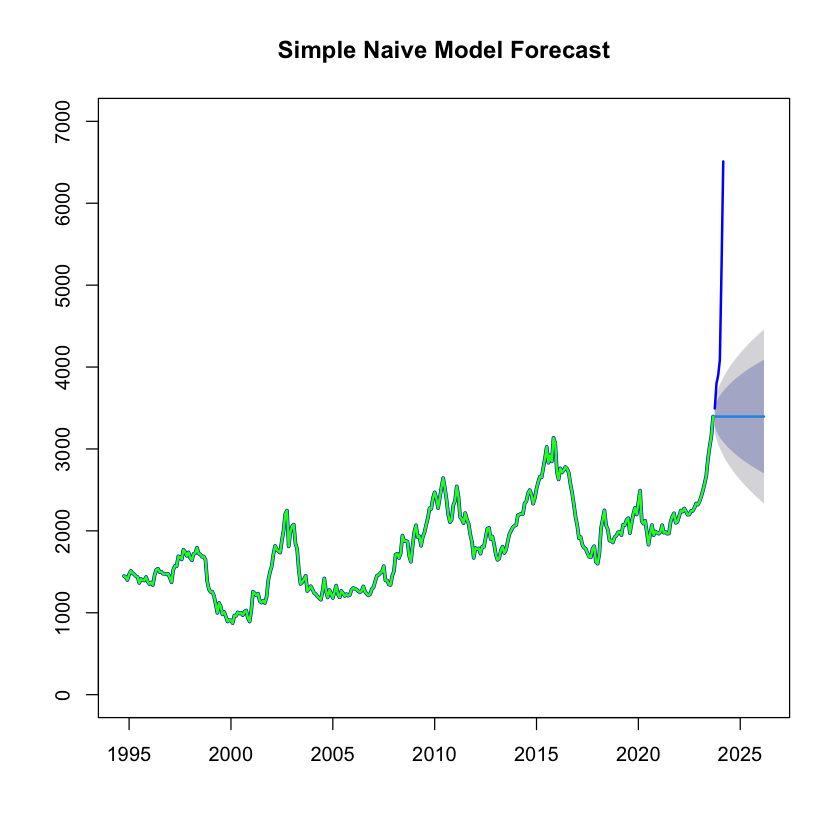

In [41]:
# Plot the forecast using meanf
plot(fcast.naive, col = 'blue', lwd = 3, ylim = c(0, 7000), 
     main = 'Simple Naive Model Forecast')

# Plot the training set up to September 2023
train_up_to_sep <- window(train, end = c(2023, 9))

lines(train_up_to_sep, col = 'green', lwd = 2)

# Plot the test set
lines(test, col = 'blue', lwd = 2)

Forecast Using Seasonal Naive Model

In [42]:
fcast.snaive <- snaive(train, h=length(train))
fcast.snaive

         Point Forecast         Lo 80    Hi 80        Lo 95    Hi 95
Oct 2023        2281.01 1783.44439950 2778.576  1520.049081 3041.971
Nov 2023        2333.84 1836.27439950 2831.406  1572.879081 3094.801
Dec 2023        2319.35 1821.78439950 2816.916  1558.389081 3080.311
Jan 2024        2357.59 1860.02439950 2855.156  1596.629081 3118.551
Feb 2024        2418.26 1920.69439950 2915.826  1657.299081 3179.221
Mar 2024        2491.37 1993.80439950 2988.936  1730.409081 3252.331
Apr 2024        2575.00 2077.43439950 3072.566  1814.039081 3335.961
May 2024        2673.46 2175.89439950 3171.026  1912.499081 3434.421
Jun 2024        2880.87 2383.30439950 3378.436  2119.909081 3641.831
Jul 2024        3028.41 2530.84439950 3525.976  2267.449081 3789.371
Aug 2024        3157.00 2659.43439950 3654.566  2396.039081 3917.961
Sep 2024        3395.58 2898.01439950 3893.146  2634.619081 4156.541
Oct 2024        2281.01 1577.34597960 2984.674  1204.848748 3357.171
Nov 2024        2333.84 1630.17597

In [43]:
accuracy(fcast.snaive, test)

ME         RMSE      MAE      MPE        MAPE     MASE   
Training set   43.56342  388.2525  296.821 -0.2156996 16.86294 1.00000
Test set     2135.60333 2350.0908 2135.603 45.2617240 45.26172 7.19492
             ACF1      Theil's U
Training set 0.9224303      NA  
Test set     0.3830578 3.29024

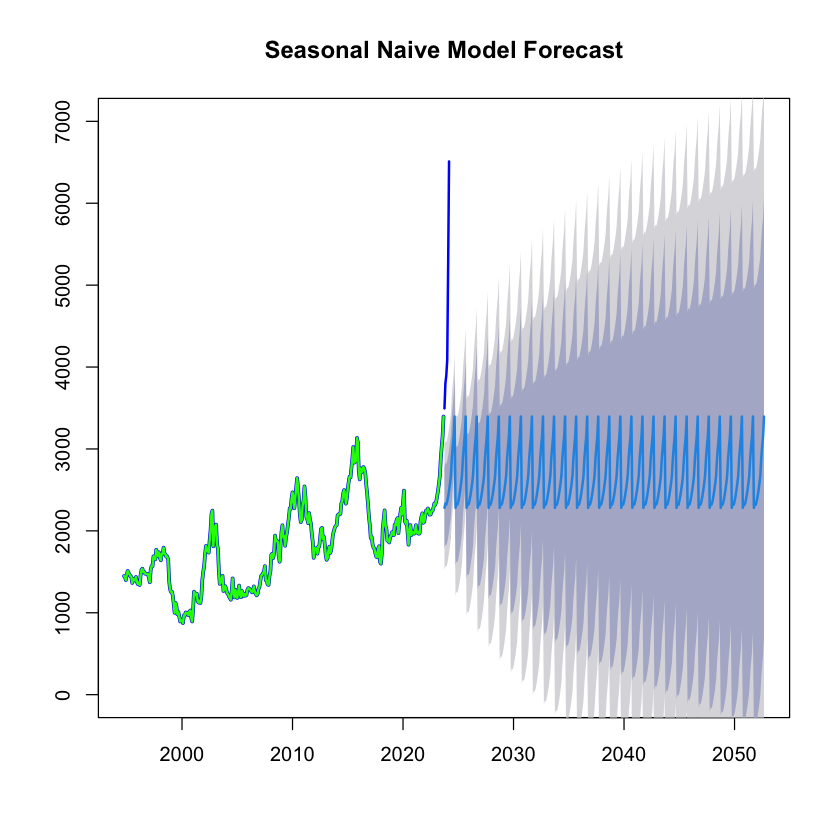

In [44]:
# Plot the forecast using meanf
plot(fcast.snaive, col = 'blue', lwd = 3, ylim = c(0, 7000), 
     main = 'Seasonal Naive Model Forecast')

# Plot the training set up to September 2023
train_up_to_sep <- window(train, end = c(2023, 9))

lines(train_up_to_sep, col = 'green', lwd = 2)

# Plot the test set
lines(test, col = 'blue', lwd = 2)

Forecast Using Drift Method

In [45]:
fcast.drift <- rwf(train, h=length(train), drift=TRUE)
fcast.drift

         Point Forecast    Lo 80    Hi 80     Lo 95     Hi 95
Oct 2023       3401.193 3274.310 3528.075 3207.1427  3595.243
Nov 2023       3406.806 3227.109 3586.502 3131.9833  3681.628
Dec 2023       3412.418 3192.021 3632.816 3075.3493  3749.487
Jan 2024       3418.031 3163.175 3672.888 3028.2617  3807.800
Feb 2024       3423.644 3138.300 3708.988 2987.2481  3860.040
Mar 2024       3429.257 3116.234 3742.279 2950.5304  3907.983
Apr 2024       3434.869 3096.288 3773.451 2917.0541  3952.685
May 2024       3440.482 3078.013 3802.952 2886.1330  3994.831
Jun 2024       3446.095 3061.097 3831.093 2857.2913  4034.898
Jul 2024       3451.708 3045.315 3858.101 2830.1831  4073.232
Aug 2024       3457.320 3030.495 3884.146 2804.5477  4110.093
Sep 2024       3462.933 3016.507 3909.360 2780.1827  4145.684
Oct 2024       3468.546 3003.244 3933.848 2756.9277  4180.164
Nov 2024       3474.159 2990.622 3957.696 2734.6526  4213.665
Dec 2024       3479.771 2978.570 3980.973 2713.2504  4246.293
Jan 2025

In [46]:
round(accuracy(fcast.drift, test),2)

ME      RMSE    MAE     MPE   MAPE  MASE ACF1 Theil's U
Training set    0.00   98.72   73.73 -0.24  4.13 0.25 0.17   NA     
Test set     1087.28 1504.81 1087.28 20.61 20.61 3.66 0.38 2.01

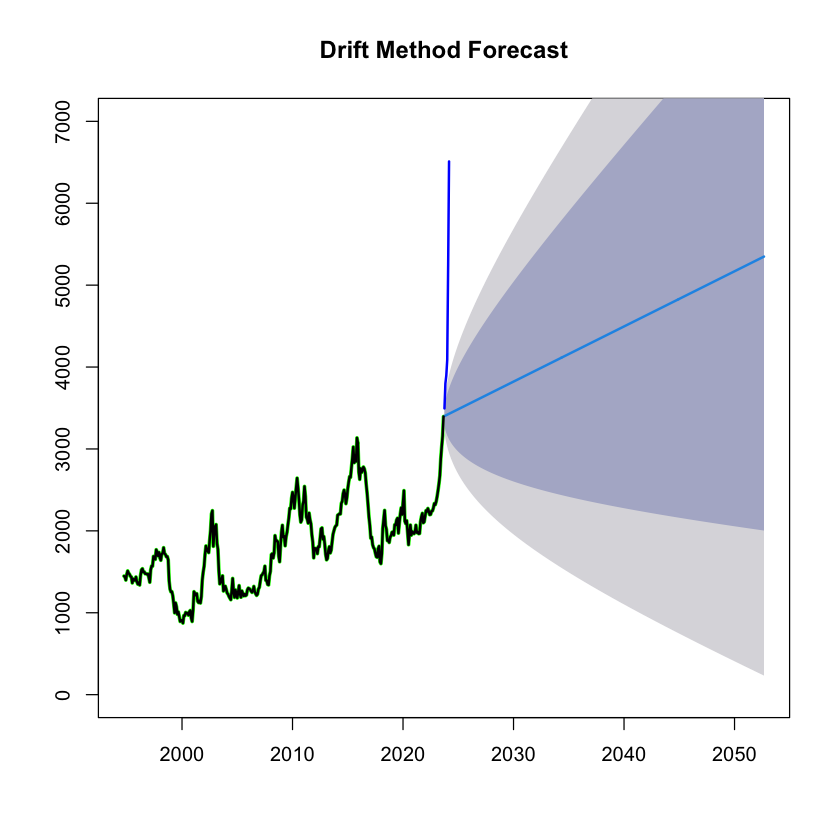

In [47]:
# Plot the forecast using meanf
plot(fcast.drift, col = 'green', lwd = 3, ylim = c(0, 7000), 
     main = 'Drift Method Forecast')

# Plot the training set up to September 2023
train_up_to_sep <- window(train, end = c(2023, 9))

lines(train_up_to_sep, col = 'black', lwd = 2)

# Plot the test set
lines(test, col = 'blue', lwd = 2)

# Forecast Using Linear Models

Mean Forecast as Linear Model

In [48]:
train_df <- data.frame(Date = as.vector(time(train)), Price = as.vector(train))

In [49]:
test_df <- data.frame(Date = as.vector(time(test)), Price = as.vector(test))

In [50]:
tail(train_df)

Date     Price  
343 2023.250 2575.00
344 2023.333 2673.46
345 2023.417 2880.87
346 2023.500 3028.41
347 2023.583 3157.00
348 2023.667 3395.58

In [51]:
head(test_df)

Date     Price  
1 2023.750 3495.03
2 2023.833 3799.15
3 2023.917 3897.04
4 2024.000 4087.54
5 2024.083 5226.12
6 2024.167 6510.16

In [52]:
mean.lm <- lm(Price ~ 1, data=train_df)
summary(mean.lm)


Call:
lm(formula = Price ~ 1, data = train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-933.18 -413.08  -15.62  333.16 1588.26 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1807.32      26.94   67.08   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 502.6 on 347 degrees of freedom


In [53]:
round(predict(mean.lm, test_df),4)

1        2        3        4        5        6 
1807.319 1807.319 1807.319 1807.319 1807.319 1807.319

In [54]:
acc <- rbind(accuracy(mean.lm), cbind(accuracy(test, predict(mean.lm, test_df)), NA))
round(acc, 2)

ME       RMSE    MAE     MPE     MAPE   MASE
Training set     0.00  501.91  412.22   -8.43  25.43  1  
Test set     -2695.19 2892.14 2695.19 -149.13 149.13 NA

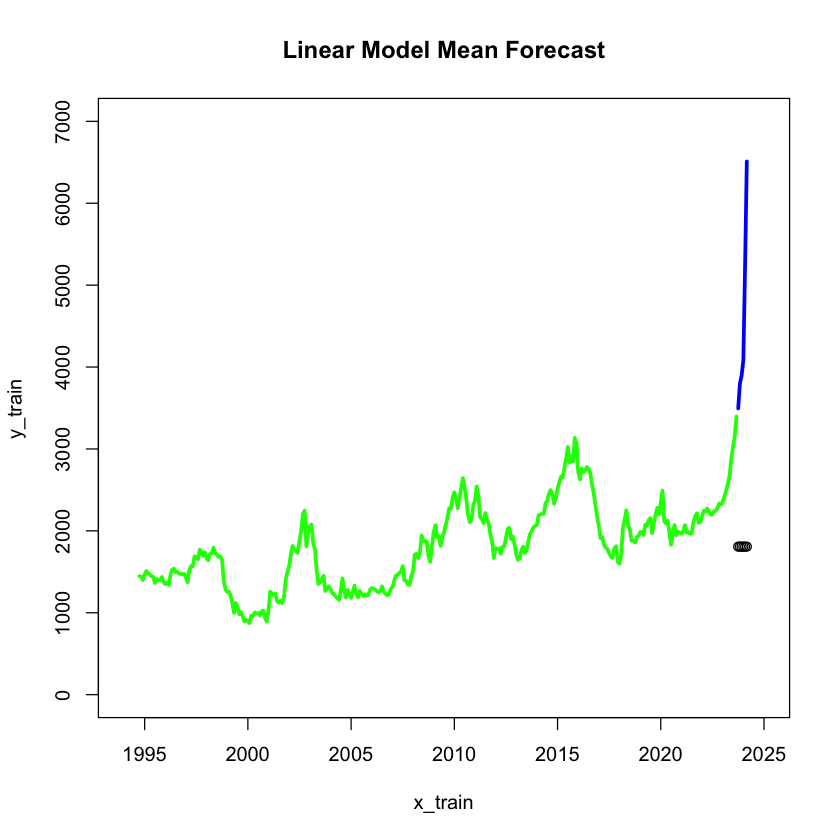

In [55]:
# Plotting the training data
x_train <- train_df$Date
y_train <- train_df$Price
plot(x_train, y_train, col = 'green', type = 'l', lwd = 3, xlim = c(1994, 2025), ylim = c(0, 7000),
    main='Linear Model Mean Forecast')

# Adding the test data
x_test <- test_df$Date
y_test <- test_df$Price
lines(x_test, y_test, col = 'blue', lwd = 3)

# Adding the predictions from the linear regression model
y_pred <- predict(mean.lm, newdata = test_df)
lines(x_test, y_pred, col = 'black', type = 'b')

Trend Forecast as Linear Model

In [56]:
trend.lm <- lm(Price ~ Date, data=train_df)
trend.lm


Call:
lm(formula = Price ~ Date, data = train_df)

Coefficients:
(Intercept)         Date  
   -82378.8         41.9  


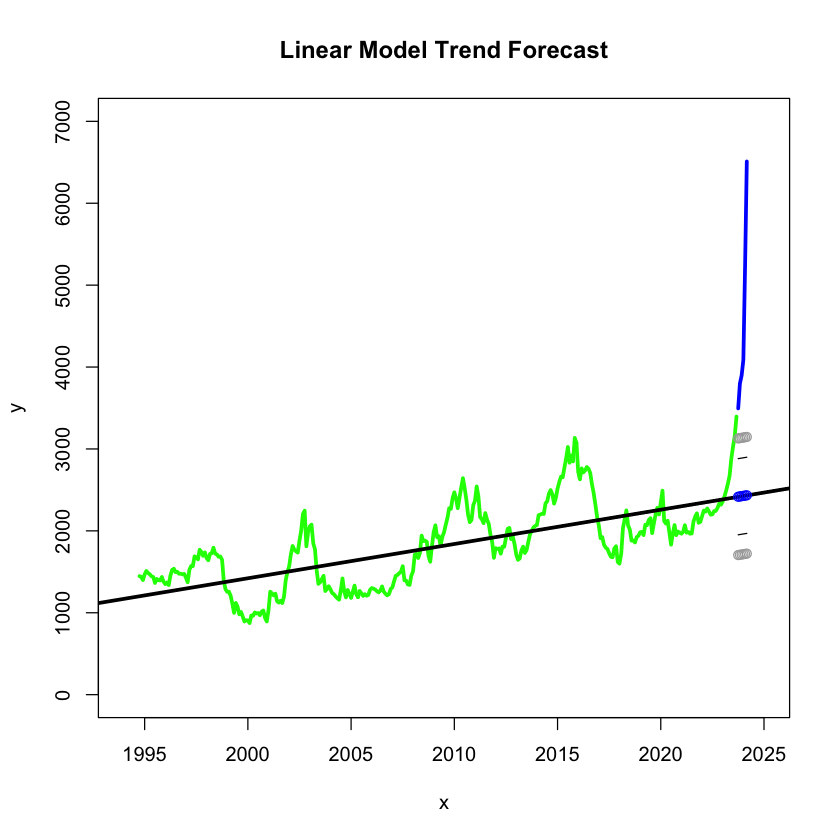

In [57]:
x <- train_df$Date 
y <- train_df$Price
plot(x, y, col='green', type='l', lwd=3, xlim = c(1994, 2025), ylim = c(0, 7000), main='Linear Model Trend Forecast')

x <- test_df$Date
y <- test_df$Price
lines(x, y, col='blue', lwd=3)

abline(trend.lm, col='black', lwd=3)

x <- test_df$Date
y <- predict(trend.lm, test_df)
lines(x, y, col='blue', type='b')

lwr80 <- predict(trend.lm, test_df, interval='prediction', level=0.80)[,2]
lines(x, lwr80, col='black')
upr80 <- predict(trend.lm, test_df, interval='prediction', level=0.80)[,3]
lines(x, upr80, col='black')


lwr95 <- predict(trend.lm, test_df, interval='prediction', level=0.95)[,2]
lines(x, lwr95, col='darkgray', type='b')
upr95 <- predict(trend.lm, test_df, interval='prediction', level=0.95)[,3]
lines(x, upr95, col='darkgray', type='b')

## Weighted Moving Averages

In [58]:
train_df <- data.frame(time=as.vector(time(train)), Price=as.vector(train))
train_df$Price_1 <- c(NA, head(train_df$Price, -1))
train_df$Price_2 <- c(NA, NA, head(train_df$Price, -2))
train_df$Price_3 <- c(NA, NA, NA, head(train_df$Price, -3))

test_df <- data.frame(time=as.vector(time(test)), Price=as.vector(test))
test_df$Price_1 <- c(tail(train_df$Price,1), head(test_df$Price, -1))
test_df$Price_2 <- c(tail(train_df$Price,2), head(test_df$Price, -2))
test_df$Price_3 <- c(tail(train_df$Price,3), head(test_df$Price, -3))

In [59]:
wma.lm <- lm(Price ~ Price_1 + Price_2 + Price_3 + 0, data=train_df)
summary(wma.lm)


Call:
lm(formula = Price ~ Price_1 + Price_2 + Price_3 + 0, data = train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-430.00  -42.49    3.57   60.56  301.72 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
Price_1  1.18561    0.05424  21.859  < 2e-16 ***
Price_2 -0.26987    0.08284  -3.258  0.00124 ** 
Price_3  0.08638    0.05452   1.584  0.11406    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 97.69 on 342 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.9973,	Adjusted R-squared:  0.9973 
F-statistic: 4.244e+04 on 3 and 342 DF,  p-value: < 2.2e-16


In [60]:
b1 <- wma.lm$coefficients[[1]]
b2 <- wma.lm$coefficients[[2]]
b3 <- wma.lm$coefficients[[3]]
b1+b2+b3

[1] 1.002114

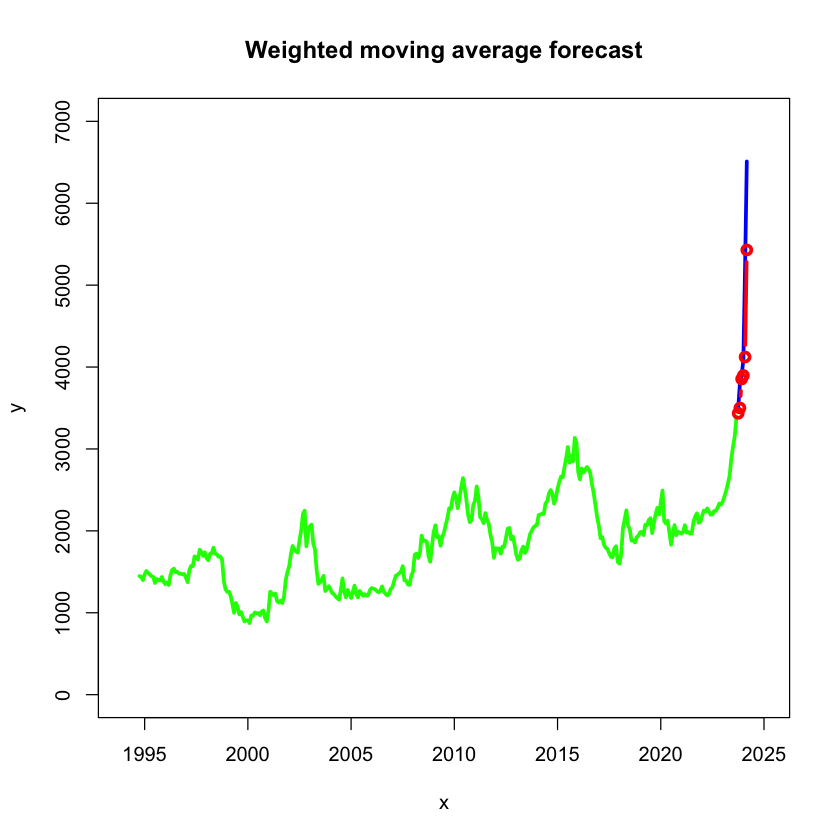

In [61]:
x <- train_df$time 
y <- train_df$Price
plot(x, y, col='green', type='l', lwd=3, xlim=c(1994, 2025), ylim=c(0, 7000), main='Weighted moving average forecast')

x <- test_df$time
y <- test_df$Price
lines(x, y, col='blue', lwd=3)

# abline(wma.lm, col='black', lwd=3)

x <- test_df$time
y <- predict(wma.lm, test_df)
lines(x, y, col='red', lwd = 3, type = 'b')

### EXPONENTIAL SMOOTHING

Using ses()

In [62]:
nhfit <- ses(train, h=length(test)+10)
nhfit

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3395.556 3268.649 3522.463 3201.469 3589.643
Nov 2023       3395.556 3216.092 3575.021 3121.089 3670.023
Dec 2023       3395.556 3175.762 3615.351 3059.410 3731.703
Jan 2024       3395.556 3141.761 3649.351 3007.411 3783.702
Feb 2024       3395.556 3111.806 3679.306 2961.598 3829.514
Mar 2024       3395.556 3084.725 3706.387 2920.181 3870.931
Apr 2024       3395.556 3059.821 3731.291 2882.093 3909.019
May 2024       3395.556 3036.641 3754.472 2846.642 3944.470
Jun 2024       3395.556 3014.869 3776.243 2813.346 3977.766
Jul 2024       3395.556 2994.278 3796.835 2781.853 4009.259
Aug 2024       3395.556 2974.692 3816.420 2751.900 4039.212
Sep 2024       3395.556 2955.978 3835.134 2723.280 4067.833
Oct 2024       3395.556 2938.029 3853.083 2695.829 4095.283
Nov 2024       3395.556 2920.758 3870.354 2669.415 4121.697
Dec 2024       3395.556 2904.094 3887.018 2643.929 4147.183
Jan 2025       3395.556 2887.976 3903.13

In [63]:
nhfit$model

Simple exponential smoothing 

Call:
 ses(y = train, h = length(test) + 10) 

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 1448.2592 

  sigma:  99.0259

     AIC     AICc      BIC 
5238.946 5239.016 5250.503 

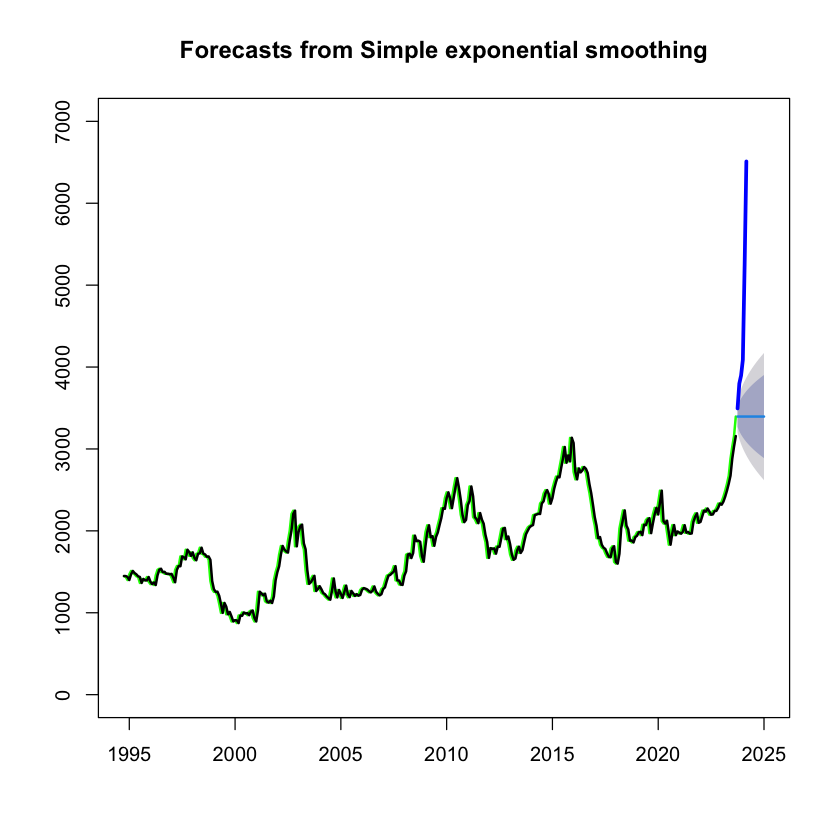

In [64]:
plot(nhfit, lw=2, col='green', ylim=c(0, 7000))

x <- as.vector(time(train))
y <- nhfit$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

In [65]:
nhfit_0.05 <- ses(train, h=length(test)+10, alpha=0.05)
nhfit_0.05

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       2400.231 2007.346 2793.117 1799.365 3001.098
Nov 2023       2400.231 2006.855 2793.608 1798.614 3001.848
Dec 2023       2400.231 2006.365 2794.098 1797.865 3002.598
Jan 2024       2400.231 2005.875 2794.587 1797.116 3003.347
Feb 2024       2400.231 2005.386 2795.076 1796.368 3004.095
Mar 2024       2400.231 2004.898 2795.565 1795.621 3004.842
Apr 2024       2400.231 2004.410 2796.053 1794.875 3005.588
May 2024       2400.231 2003.923 2796.540 1794.130 3006.333
Jun 2024       2400.231 2003.437 2797.026 1793.386 3007.077
Jul 2024       2400.231 2002.951 2797.512 1792.643 3007.820
Aug 2024       2400.231 2002.465 2797.998 1791.900 3008.562
Sep 2024       2400.231 2001.980 2798.482 1791.159 3009.304
Oct 2024       2400.231 2001.496 2798.967 1790.419 3010.044
Nov 2024       2400.231 2001.013 2799.450 1789.679 3010.784
Dec 2024       2400.231 2000.530 2799.933 1788.940 3011.523
Jan 2025       2400.231 2000.047 2800.41

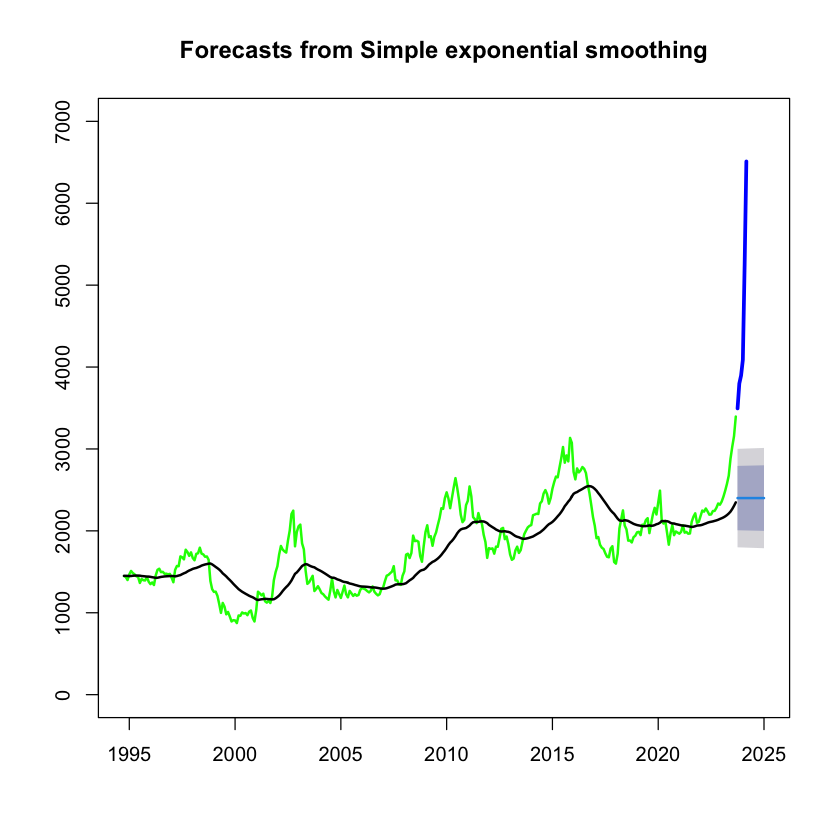

In [66]:
plot(nhfit_0.05, lw=2, col='green', ylim=c(0, 7000))

x <- as.vector(time(train))
y <- nhfit_0.05$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

In [67]:
nhfit_0.4 <- ses(train, h=length(test)+10, alpha=0.4)
nhfit_0.4

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3132.171 2961.162 3303.180 2870.635 3393.707
Nov 2023       3132.171 2947.988 3316.353 2850.488 3413.853
Dec 2023       3132.171 2935.696 3328.645 2831.689 3432.652
Jan 2024       3132.171 2924.129 3340.212 2813.999 3450.343
Feb 2024       3132.171 2913.172 3351.169 2797.242 3467.100
Mar 2024       3132.171 2902.738 3361.603 2781.284 3483.058
Apr 2024       3132.171 2892.758 3371.583 2766.021 3498.321
May 2024       3132.171 2883.178 3381.164 2751.369 3512.973
Jun 2024       3132.171 2873.953 3390.389 2737.260 3527.081
Jul 2024       3132.171 2865.046 3399.295 2723.639 3540.703
Aug 2024       3132.171 2856.427 3407.915 2710.457 3553.885
Sep 2024       3132.171 2848.069 3416.272 2697.675 3566.667
Oct 2024       3132.171 2839.950 3424.391 2685.258 3579.083
Nov 2024       3132.171 2832.051 3432.290 2673.177 3591.164
Dec 2024       3132.171 2824.354 3439.987 2661.406 3602.935
Jan 2025       3132.171 2816.846 3447.49

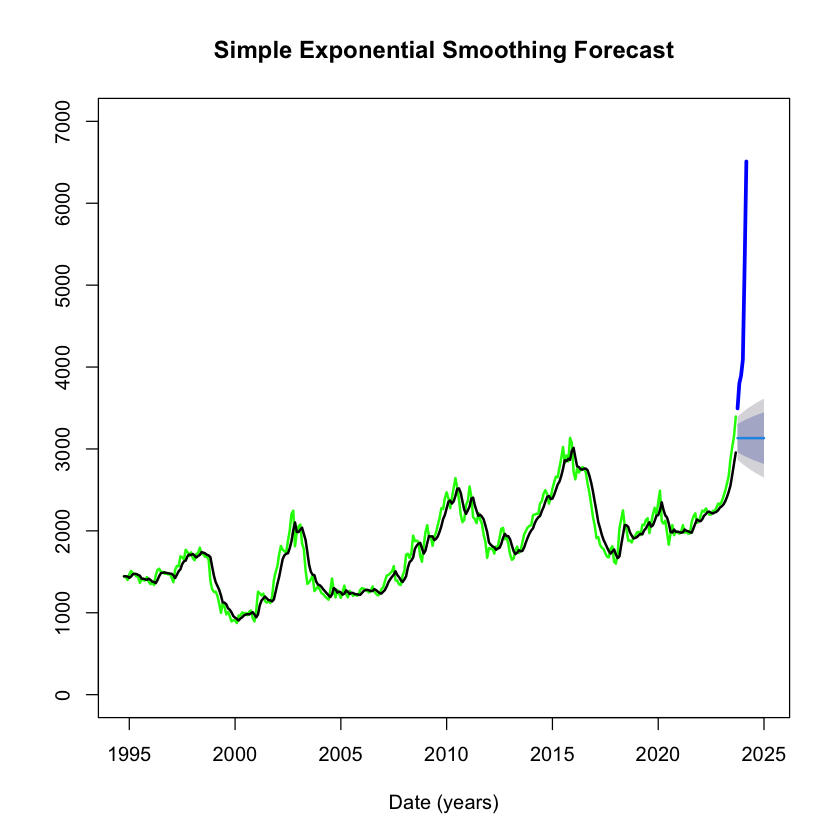

In [68]:
plot(nhfit_0.4, lw=2, col='green', ylim=c(0, 7000), main='Simple Exponential Smoothing Forecast', xlab='Date (years)')

x <- as.vector(time(train))
y <- nhfit_0.4$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

In [69]:
nhfit_0.7 <- ses(train, h=length(test)+10, alpha=0.7)
nhfit_0.7

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3306.448 3167.565 3445.331 3094.045 3518.851
Nov 2023       3306.448 3136.920 3475.977 3047.177 3565.719
Dec 2023       3306.448 3111.023 3501.874 3007.571 3605.326
Jan 2024       3306.448 3088.177 3524.720 2972.631 3640.266
Feb 2024       3306.448 3067.505 3545.392 2941.016 3671.880
Mar 2024       3306.448 3048.485 3564.412 2911.927 3700.970
Apr 2024       3306.448 3030.774 3582.123 2884.840 3728.056
May 2024       3306.448 3014.134 3598.763 2859.392 3753.505
Jun 2024       3306.448 2998.391 3614.506 2835.315 3777.581
Jul 2024       3306.448 2983.415 3629.482 2812.411 3800.485
Aug 2024       3306.448 2969.103 3643.794 2790.523 3822.374
Sep 2024       3306.448 2955.374 3657.523 2769.526 3843.370
Oct 2024       3306.448 2942.162 3670.735 2749.320 3863.576
Nov 2024       3306.448 2929.413 3683.484 2729.822 3883.075
Dec 2024       3306.448 2917.080 3695.816 2710.962 3901.935
Jan 2025       3306.448 2905.127 3707.77

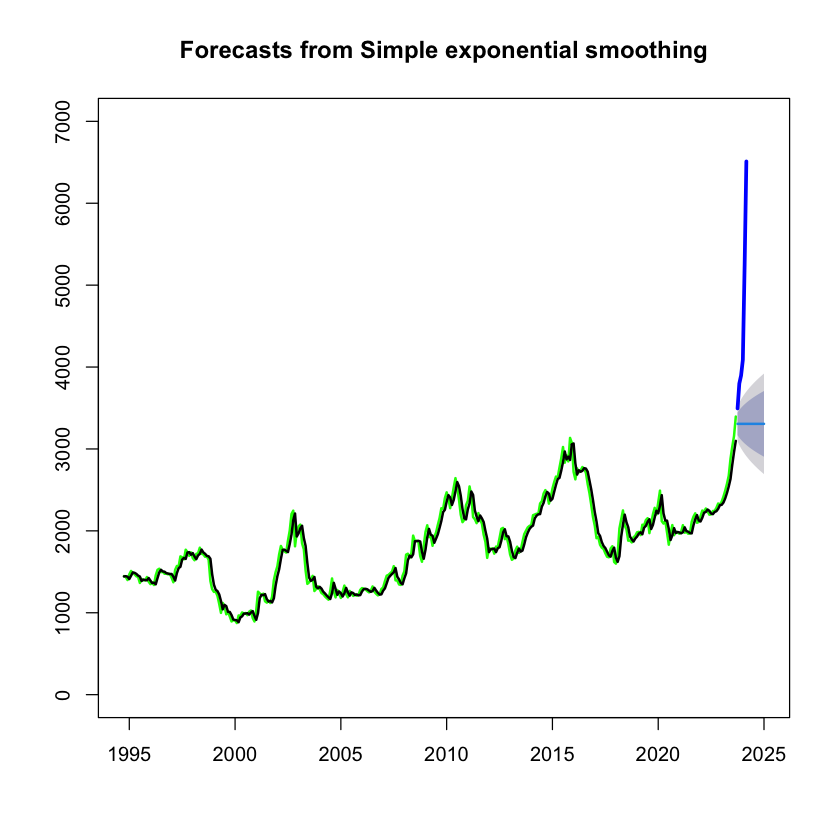

In [70]:
plot(nhfit_0.7, lw=2, col='green', ylim=c(0, 7000))

x <- as.vector(time(train))
y <- nhfit_0.7$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

Using ets('ANN')

In [71]:
nhfit2 <- ets(train, model='ANN')

In [72]:
fc2 <- forecast(nhfit2, h=length(test)+50)

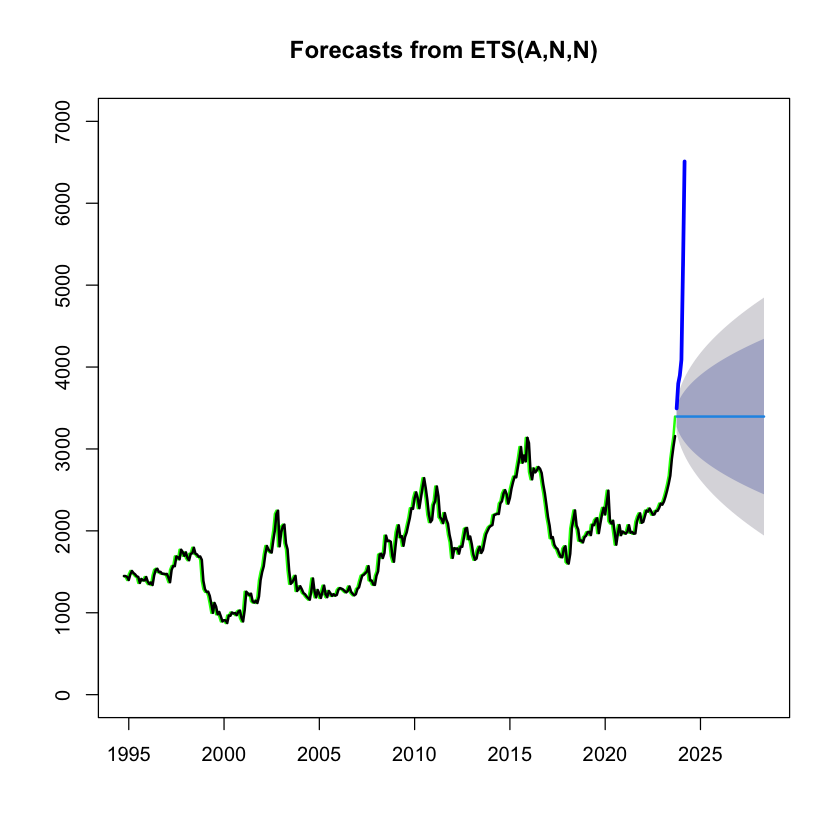

In [73]:
plot(fc2, lw=2, col='green', ylim=c(0, 7000))

x <- as.vector(time(train))
y <- nhfit2$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

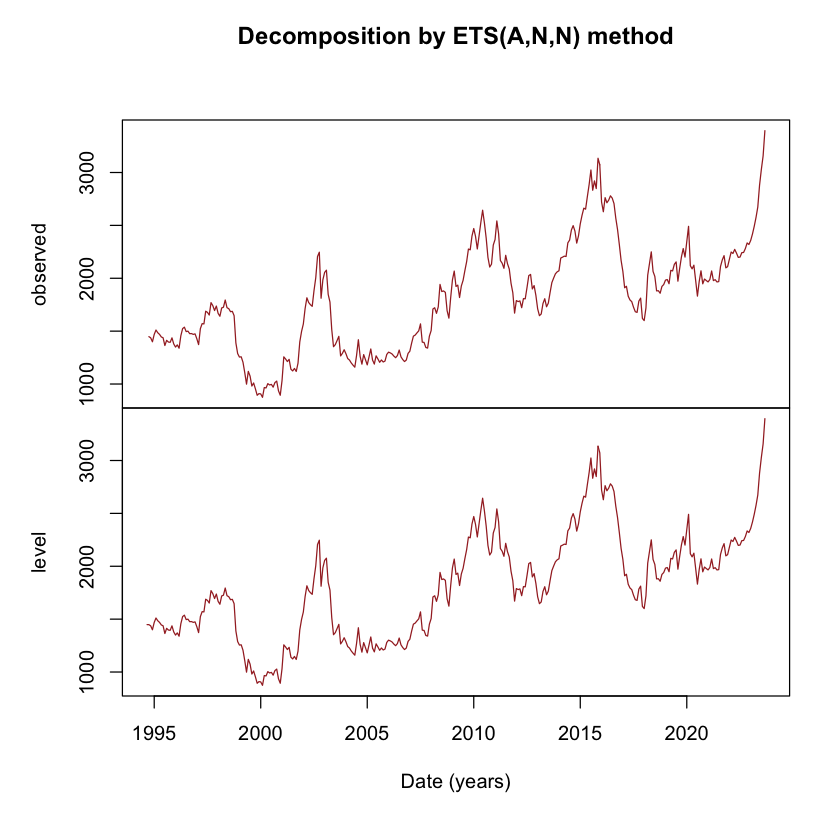

In [74]:
plot(nhfit2, col='brown', xlab='Date (years)')

#### Comparing ses() and ets('ANN')

Comparing Forecasts

In [75]:
fc2

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3395.556 3268.649 3522.463 3201.469 3589.643
Nov 2023       3395.556 3216.092 3575.021 3121.089 3670.023
Dec 2023       3395.556 3175.762 3615.351 3059.410 3731.703
Jan 2024       3395.556 3141.761 3649.351 3007.411 3783.702
Feb 2024       3395.556 3111.806 3679.306 2961.599 3829.514
Mar 2024       3395.556 3084.725 3706.387 2920.181 3870.931
Apr 2024       3395.556 3059.821 3731.291 2882.093 3909.019
May 2024       3395.556 3036.641 3754.471 2846.642 3944.470
Jun 2024       3395.556 3014.869 3776.243 2813.346 3977.766
Jul 2024       3395.556 2994.278 3796.835 2781.854 4009.259
Aug 2024       3395.556 2974.692 3816.420 2751.900 4039.212
Sep 2024       3395.556 2955.978 3835.134 2723.280 4067.833
Oct 2024       3395.556 2938.029 3853.083 2695.829 4095.283
Nov 2024       3395.556 2920.758 3870.354 2669.415 4121.697
Dec 2024       3395.556 2904.094 3887.018 2643.930 4147.183
Jan 2025       3395.556 2887.976 3903.13

In [76]:
nhfit

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3395.556 3268.649 3522.463 3201.469 3589.643
Nov 2023       3395.556 3216.092 3575.021 3121.089 3670.023
Dec 2023       3395.556 3175.762 3615.351 3059.410 3731.703
Jan 2024       3395.556 3141.761 3649.351 3007.411 3783.702
Feb 2024       3395.556 3111.806 3679.306 2961.598 3829.514
Mar 2024       3395.556 3084.725 3706.387 2920.181 3870.931
Apr 2024       3395.556 3059.821 3731.291 2882.093 3909.019
May 2024       3395.556 3036.641 3754.472 2846.642 3944.470
Jun 2024       3395.556 3014.869 3776.243 2813.346 3977.766
Jul 2024       3395.556 2994.278 3796.835 2781.853 4009.259
Aug 2024       3395.556 2974.692 3816.420 2751.900 4039.212
Sep 2024       3395.556 2955.978 3835.134 2723.280 4067.833
Oct 2024       3395.556 2938.029 3853.083 2695.829 4095.283
Nov 2024       3395.556 2920.758 3870.354 2669.415 4121.697
Dec 2024       3395.556 2904.094 3887.018 2643.929 4147.183
Jan 2025       3395.556 2887.976 3903.13

In [77]:
round(accuracy(nhfit, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set    5.596   98.741   73.685  0.097  4.110 0.248 0.168    NA    
Test set     1106.951 1525.059 1106.951 21.023 21.023 3.729 0.384 2.039

In [78]:
round(accuracy(fc2, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set    5.596   98.741   73.685  0.097  4.110 0.248 0.168    NA    
Test set     1106.951 1525.059 1106.951 21.023 21.023 3.729 0.384 2.039

In [79]:
round(accuracy(nhfit, test),8)

ME         RMSE       MAE        MPE         MAPE      MASE     
Training set    5.59624   98.74098   73.68487  0.09705144  4.110025 0.2482468
Test set     1106.95053 1525.05913 1106.95053 21.02270961 21.022710 3.7293540
             ACF1      Theil's U
Training set 0.1679183       NA 
Test set     0.3844148 2.039491

In [80]:
round(accuracy(fc2, test),8)

ME          RMSE       MAE        MPE         MAPE      MASE     
Training set    5.596234   98.74098   73.68488  0.09705097  4.110025 0.2482469
Test set     1106.950550 1525.05914 1106.95055 21.02271016 21.022710 3.7293541
             ACF1      Theil's U
Training set 0.1679184       NA 
Test set     0.3844148 2.039491

### Comparing Models

In [81]:
nhfit2

ETS(A,N,N) 

Call:
 ets(y = train, model = "ANN") 

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 1448.2616 

  sigma:  99.0259

     AIC     AICc      BIC 
5238.946 5239.016 5250.503 

In [82]:
nhfit$model

Simple exponential smoothing 

Call:
 ses(y = train, h = length(test) + 10) 

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 1448.2592 

  sigma:  99.0259

     AIC     AICc      BIC 
5238.946 5239.016 5250.503 

## Holt Method

In [83]:
nhfit.holt <- holt(train, h=length(test)+50)

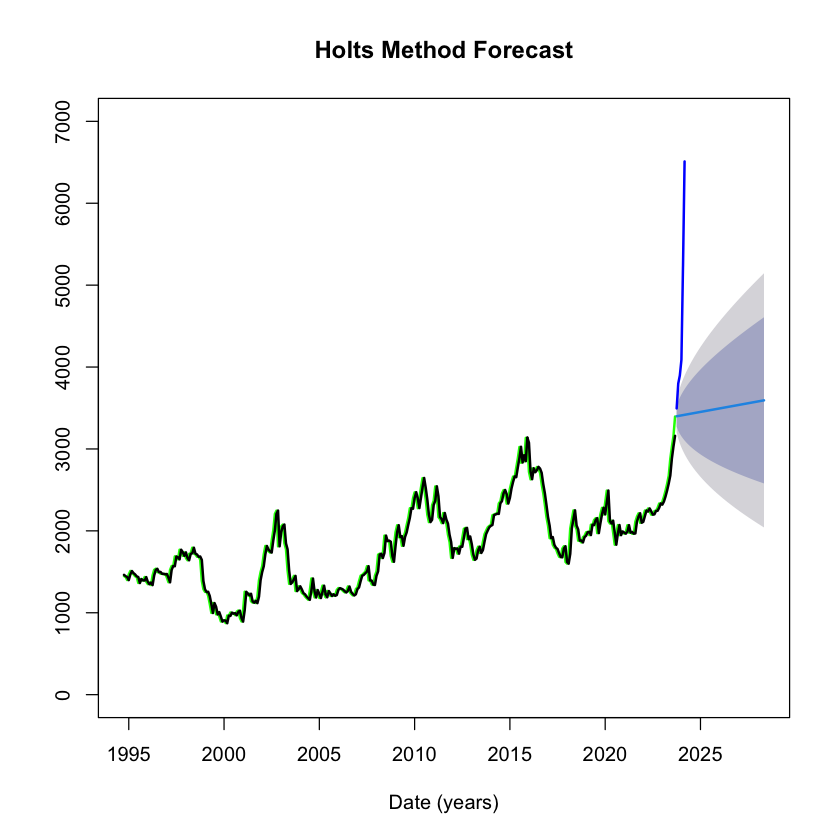

In [84]:
plot(nhfit.holt, lw=2, col='green', ylim=c(0,7000), main='Holts Method Forecast', xlab='Date (years)')

x <- as.vector(time(train))
y <- nhfit.holt$model$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=2)

## Using `ets` with `model='AAN'`

In [85]:
nhfit3 <- ets(train, model='AAN')

In [86]:
fc3 <- forecast(nhfit3, h=length(test)+50)

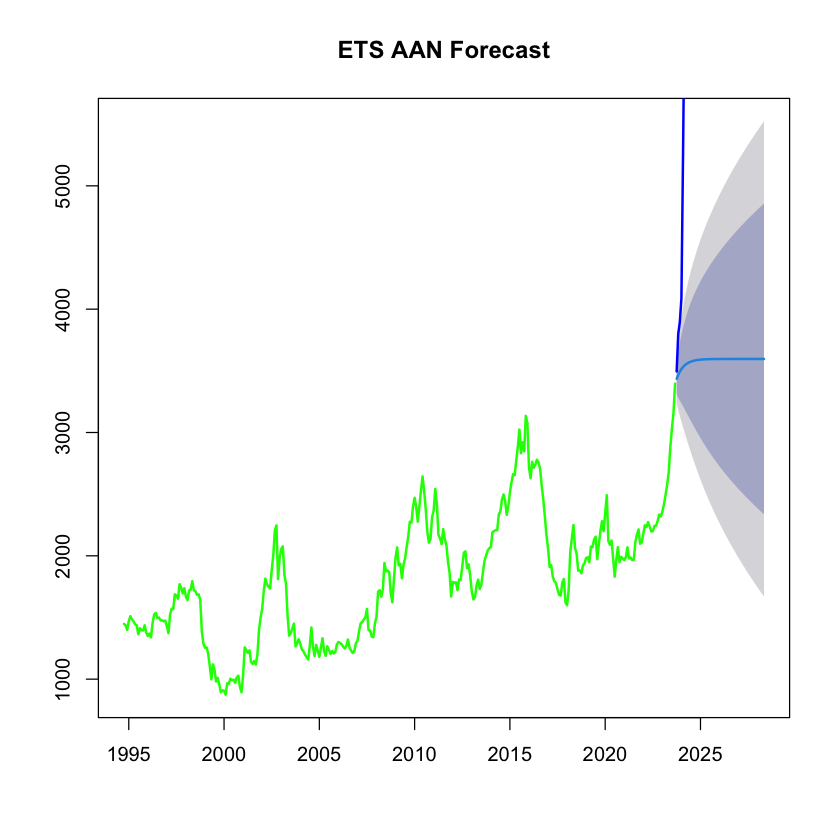

In [87]:
plot(fc3, lw=2, col='green', main='ETS AAN Forecast')

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=2)

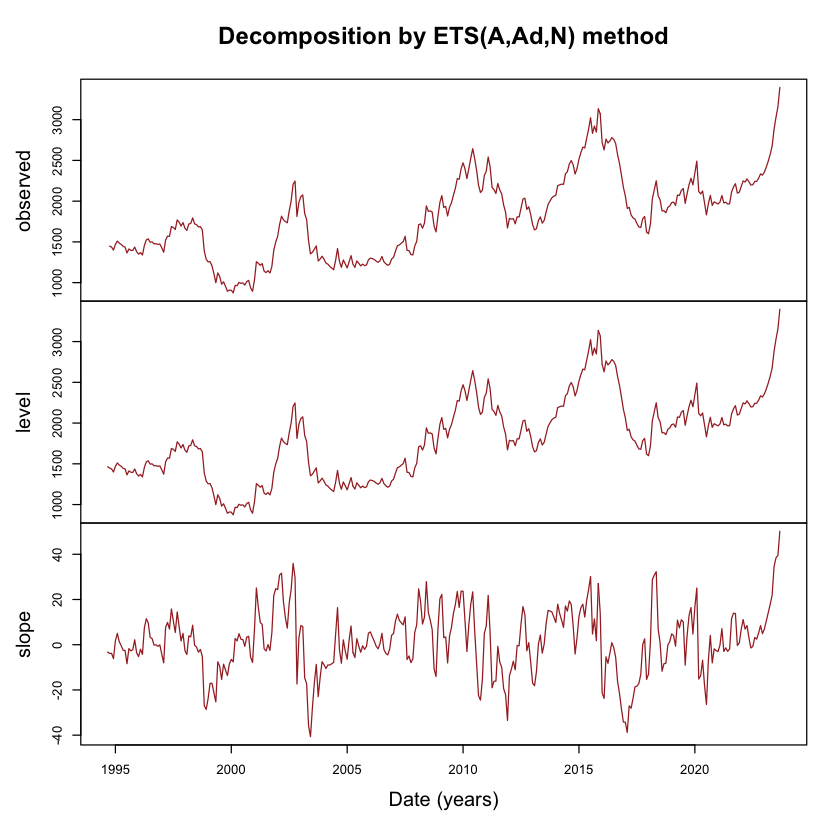

In [88]:
plot(nhfit3, col='brown', xlab='Date (years)')

## Comparing holt() and forecast(ets('AAN'))

Comparing Forecasts

In [89]:
fc3

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3435.705 3309.020 3562.390 3241.957 3629.453
Nov 2023       3467.822 3282.128 3653.517 3183.827 3751.818
Dec 2023       3493.517 3259.113 3727.920 3135.027 3852.006
Jan 2024       3514.072 3236.389 3791.755 3089.393 3938.751
Feb 2024       3530.517 3213.218 3847.816 3045.249 4015.784
Mar 2024       3543.673 3189.543 3897.803 3002.078 4085.268
Apr 2024       3554.198 3165.503 3942.893 2959.740 4148.656
May 2024       3562.618 3141.275 3983.961 2918.229 4207.007
Jun 2024       3569.354 3117.027 4021.682 2877.579 4261.129
Jul 2024       3574.743 3092.898 4056.589 2837.824 4311.662
Aug 2024       3579.054 3068.999 4089.110 2798.992 4359.117
Sep 2024       3582.504 3045.413 4119.594 2761.094 4403.913
Oct 2024       3585.263 3022.200 4148.326 2724.132 4446.393
Nov 2024       3587.470 2999.401 4175.539 2688.097 4486.844
Dec 2024       3589.236 2977.043 4201.429 2652.968 4525.505
Jan 2025       3590.649 2955.140 4226.15

In [90]:
nhfit.holt

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3399.091 3271.764 3526.419 3204.361 3593.822
Nov 2023       3402.626 3222.356 3582.896 3126.927 3678.325
Dec 2023       3406.161 3185.122 3627.199 3068.112 3744.210
Jan 2024       3409.695 3154.167 3665.224 3018.898 3800.493
Feb 2024       3413.230 3127.209 3699.252 2975.798 3850.662
Mar 2024       3416.765 3103.080 3730.450 2937.026 3896.504
Apr 2024       3420.300 3081.088 3759.512 2901.520 3939.080
May 2024       3423.835 3060.781 3786.888 2868.592 3979.077
Jun 2024       3427.369 3041.846 3812.893 2837.762 4016.977
Jul 2024       3430.904 3024.055 3837.753 2808.682 4053.126
Aug 2024       3434.439 3007.237 3861.641 2781.090 4087.788
Sep 2024       3437.974 2991.259 3884.688 2754.782 4121.165
Oct 2024       3441.508 2976.015 3907.002 2729.597 4153.420
Nov 2024       3445.043 2961.418 3928.668 2705.403 4184.683
Dec 2024       3448.578 2947.400 3949.756 2682.092 4215.063
Jan 2025       3452.113 2933.900 3970.32

In [91]:
round(accuracy(fc3, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set    4.534   98.140   72.570  0.094  4.062 0.244 0.101  NA      
Test set     1004.956 1430.624 1004.956 18.802 18.802 3.386 0.379 1.9

In [92]:
round(accuracy(nhfit.holt, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set    5.552   98.781   73.653  0.113  4.108 0.248 0.167    NA    
Test set     1094.579 1512.312 1094.579 20.761 20.761 3.688 0.384 2.021

In [93]:
nhfit3

ETS(A,Ad,N) 

Call:
 ets(y = train, model = "AAN") 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0898 
    phi   = 0.8 

  Initial states:
    l = 1464.9379 
    b = -3.2205 

  sigma:  98.8527

     AIC     AICc      BIC 
5240.697 5240.944 5263.810 

In [94]:
nhfit.holt$model

Holt's method 

Call:
 holt(y = train, h = length(test) + 50) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0023 

  Initial states:
    l = 1463.9748 
    b = -0.9774 

  sigma:  99.3541

     AIC     AICc      BIC 
5243.232 5243.407 5262.493 

# Using `ets` with `model='MNN'`

In [95]:
nhfit4 <- ets(train, model='MNN')

In [96]:
fc4 <- forecast(nhfit4, h=length(test) + 10)

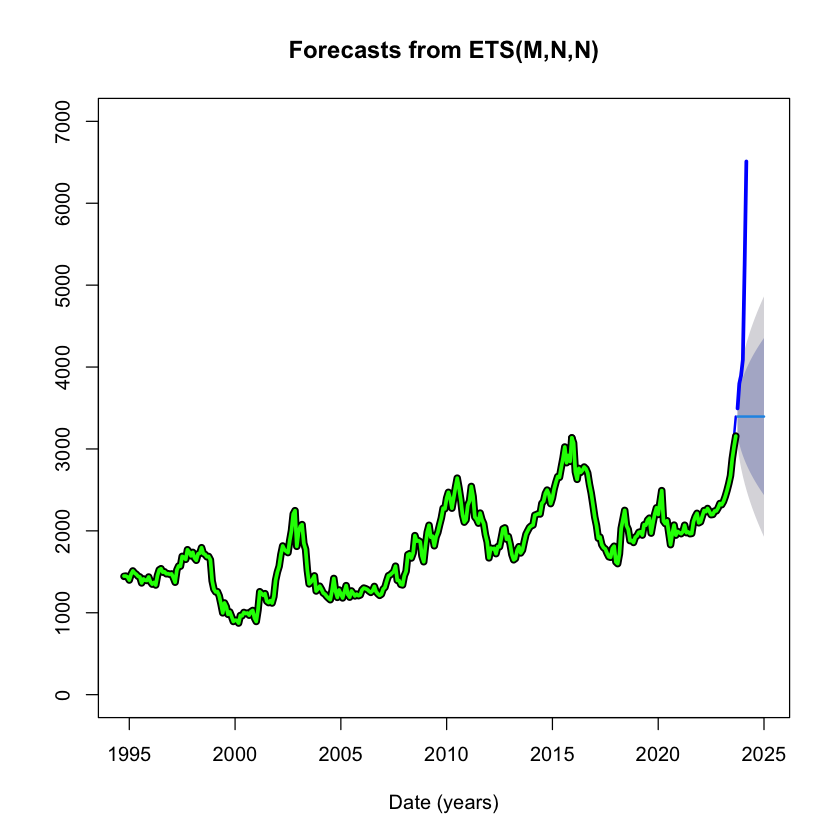

In [97]:
plot(fc4, lw=2, col='blue', ylim=c(0,7000), xlab='Date (years)')

x <- as.vector(time(train))
y <- nhfit4$fitted
lines(x, y, col='black', lw=6)

x <- as.vector(time(train))
y <- nhfit2$fitted
lines(x, y, col='green', lw=3)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

In [98]:
round(accuracy(fc4, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set    5.608   98.741   73.695  0.098  4.111 0.248 0.168    NA    
Test set     1106.951 1525.059 1106.951 21.023 21.023 3.729 0.384 2.039

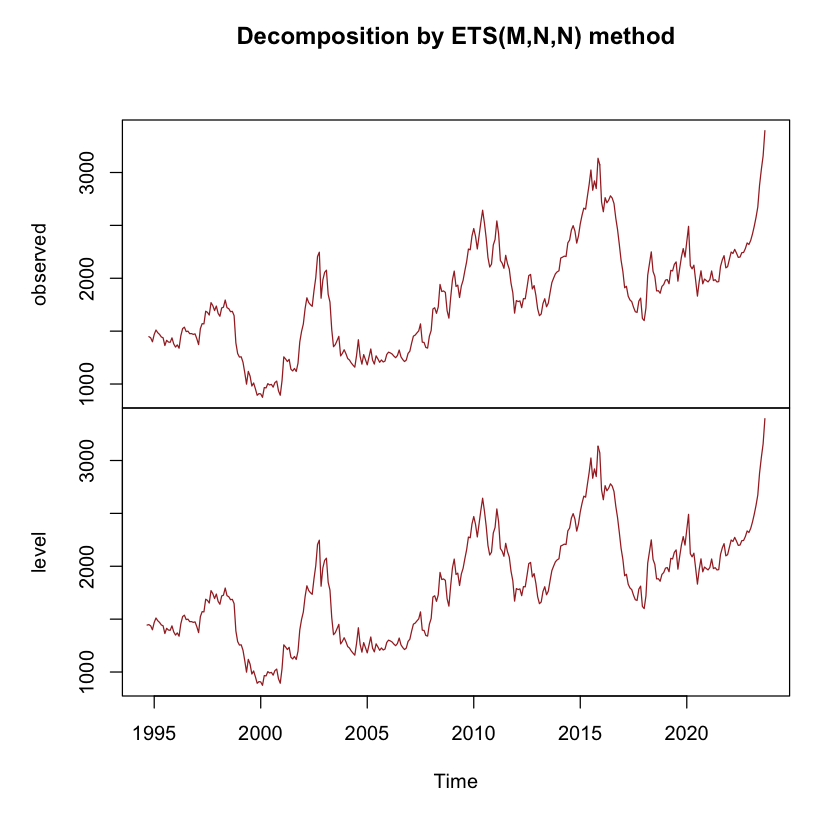

In [99]:
plot(nhfit4, col='brown')

In [100]:
fc4

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3395.556 3158.348 3632.764 3032.777 3758.335
Nov 2023       3395.556 3059.861 3731.252 2882.154 3908.958
Dec 2023       3395.556 2984.116 3806.996 2766.313 4024.799
Jan 2024       3395.556 2920.117 3870.995 2668.435 4122.677
Feb 2024       3395.556 2863.607 3927.505 2582.010 4209.102
Mar 2024       3395.556 2812.403 3978.709 2503.701 4287.411
Apr 2024       3395.556 2765.212 4025.900 2431.528 4359.585
May 2024       3395.556 2721.189 4069.923 2364.201 4426.911
Jun 2024       3395.556 2679.750 4111.362 2300.825 4490.287
Jul 2024       3395.556 2640.469 4150.644 2240.749 4550.363
Aug 2024       3395.556 2603.024 4188.088 2183.482 4607.630
Sep 2024       3395.556 2567.166 4223.946 2128.643 4662.469
Oct 2024       3395.556 2532.697 4258.415 2075.928 4715.185
Nov 2024       3395.556 2499.457 4291.655 2025.091 4766.021
Dec 2024       3395.556 2467.313 4323.799 1975.931 4815.182
Jan 2025       3395.556 2436.154 4354.95

In [101]:
nhfit4

ETS(M,N,N) 

Call:
 ets(y = train, model = "MNN") 

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 1444.0855 

  sigma:  0.0545

     AIC     AICc      BIC 
5206.080 5206.150 5217.637 

# Using `ets` with `model='MMN'`

In [102]:
nhfit5 <- ets(train, model='MMN')

In [103]:
fc5 <- forecast(nhfit5, h=length(test) + 10)

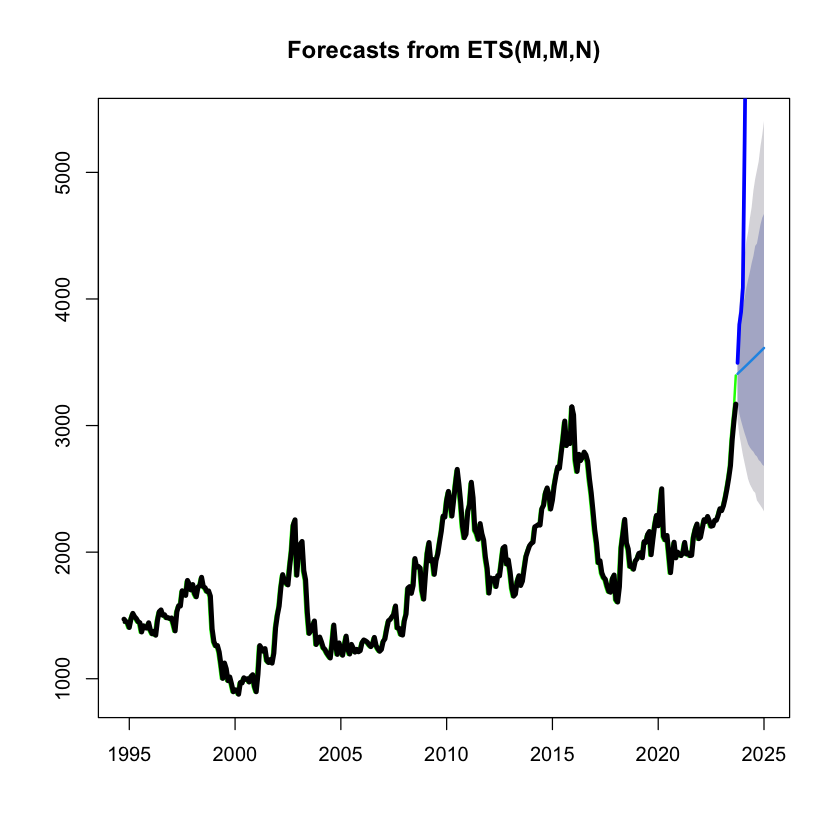

In [104]:
plot(fc5, lw=2, col='green')

x <- as.vector(time(train))
y <- nhfit5$fitted
lines(x, y, col='black', lw=4)

x <- as.vector(time(train))
y <- nhfit4$fitted
lines(x, y, col='black', lw=2)

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=3)

In [105]:
round(accuracy(fc5, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set   -1.410   98.677   73.481 -0.292  4.122 0.248 0.166   NA     
Test set     1060.507 1477.212 1060.507 20.041 20.041 3.573 0.381 1.97

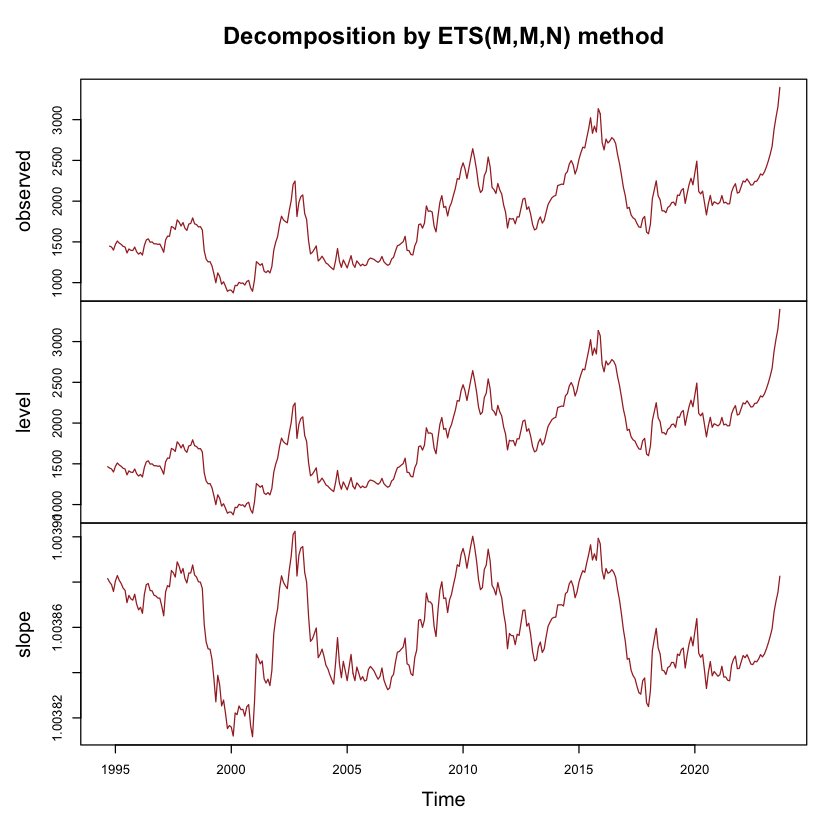

In [106]:
plot(nhfit5, col='brown')

In [107]:
fc5

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Oct 2023       3408.741 3180.699 3646.886 3042.800 3767.913
Nov 2023       3421.975 3093.837 3758.405 2928.577 3942.375
Dec 2023       3435.262 3038.439 3854.551 2850.528 4096.468
Jan 2024       3448.599 2987.647 3945.060 2770.525 4232.001
Feb 2024       3461.989 2940.067 4006.208 2704.127 4341.435
Mar 2024       3475.430 2898.051 4089.447 2639.576 4457.697
Apr 2024       3488.924 2852.246 4155.937 2576.529 4530.677
May 2024       3502.470 2826.902 4213.906 2536.630 4638.611
Jun 2024       3516.069 2807.911 4283.169 2509.605 4724.318
Jul 2024       3529.720 2793.364 4339.663 2483.149 4856.964
Aug 2024       3543.424 2768.253 4419.075 2469.153 4948.022
Sep 2024       3557.182 2755.666 4438.292 2409.164 5017.346
Oct 2024       3570.993 2727.504 4513.197 2388.555 5087.692
Nov 2024       3584.858 2715.085 4588.038 2368.314 5205.647
Dec 2024       3598.776 2691.851 4641.747 2346.975 5295.040
Jan 2025       3612.749 2680.595 4671.72

In [108]:
nhfit5

ETS(M,M,N) 

Call:
 ets(y = train, model = "MMN") 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 1e-04 

  Initial states:
    l = 1464.6037 
    b = 1.0039 

  sigma:  0.0543

     AIC     AICc      BIC 
5208.398 5208.574 5227.659 

# Using `ets` with `model='ZZZ'`

In [109]:
nhfit6 <- ets(train, model='ZZZ')

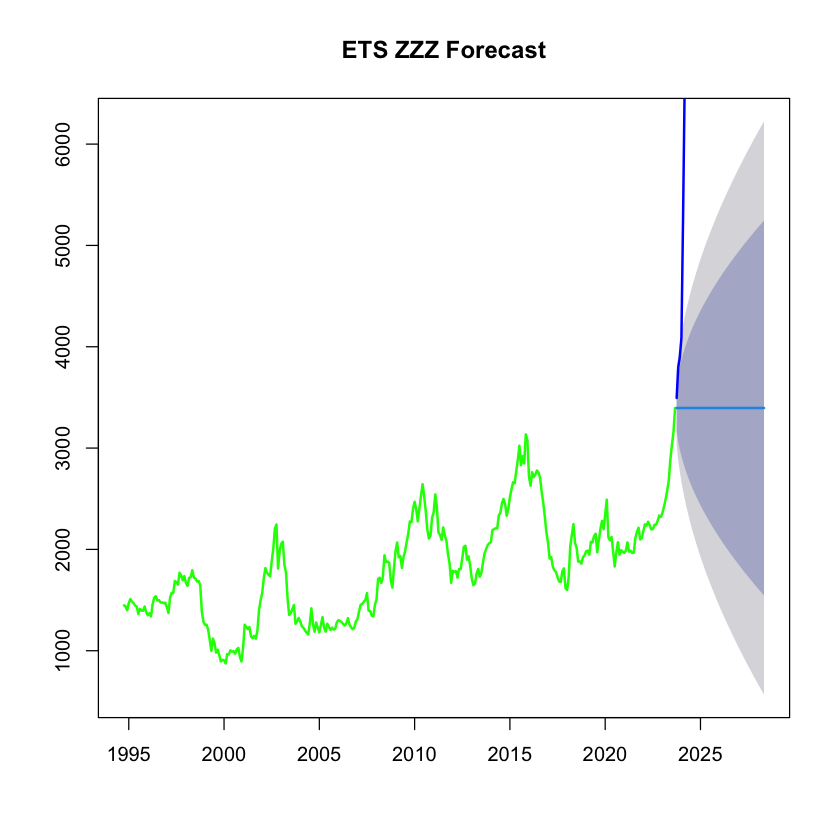

In [110]:
fc7 <- forecast(nhfit6, h=length(test)+50)

plot(fc7, lw=2, col='green', main='ETS ZZZ Forecast')

x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=2)

In [111]:
round(accuracy(fc7, test),3)

ME       RMSE     MAE      MPE    MAPE   MASE  ACF1  Theil's U
Training set    5.608   98.741   73.695  0.098  4.111 0.248 0.168    NA    
Test set     1106.951 1525.059 1106.951 21.023 21.023 3.729 0.384 2.039

In [112]:
nhfit6

ETS(M,N,N) 

Call:
 ets(y = train, model = "ZZZ") 

  Smoothing parameters:
    alpha = 0.9999 

  Initial states:
    l = 1444.0855 

  sigma:  0.0545

     AIC     AICc      BIC 
5206.080 5206.150 5217.637 

In [113]:
sprintf("ANN AIC : %f", nhfit2$aicc)
sprintf("AAN AIC : %f", nhfit3$aicc)
sprintf("MMN AIC : %f", nhfit5$aicc)
sprintf("MNN AIC : %f", nhfit4$aicc)
sprintf("ZZZ AIC : %f", nhfit6$aicc)

[1] "ANN AIC : 5239.016260"

[1] "AAN AIC : 5240.943551"

[1] "MMN AIC : 5208.573854"

[1] "MNN AIC : 5206.149766"

[1] "ZZZ AIC : 5206.149766"

# ARIMA/SARIMA

Apply log-Transform to Achieve Stationary Variance

In [114]:
ts_cocoa_log <- log(ts_cocoa)

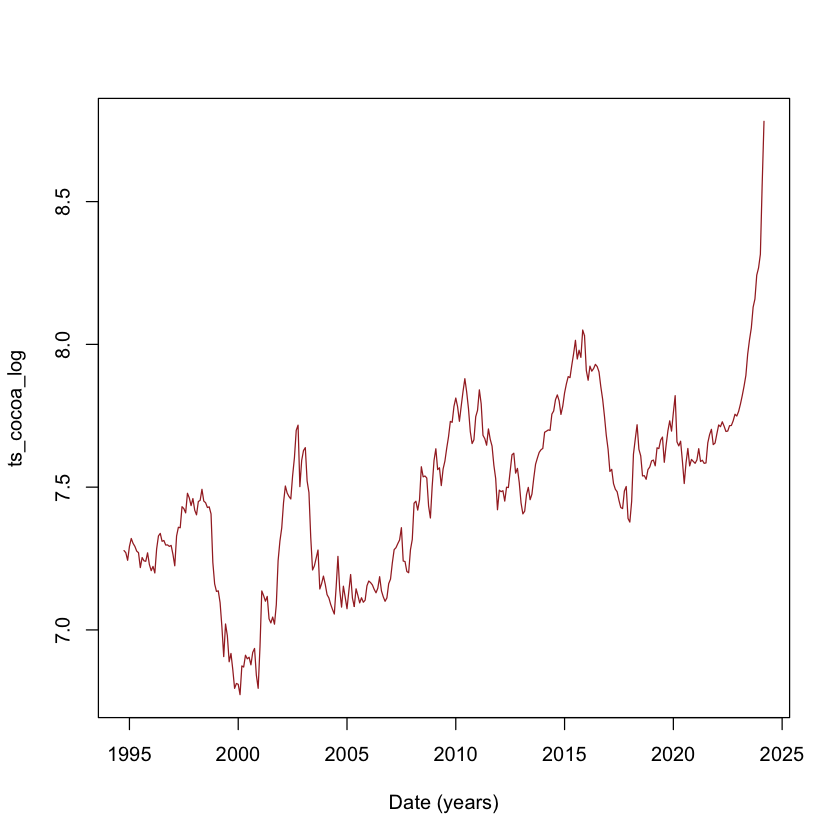

In [115]:
plot(ts_cocoa_log, col='brown', xlab='Date (years)')

Apply Seasonal Difference to Remove Seasonality and Trend

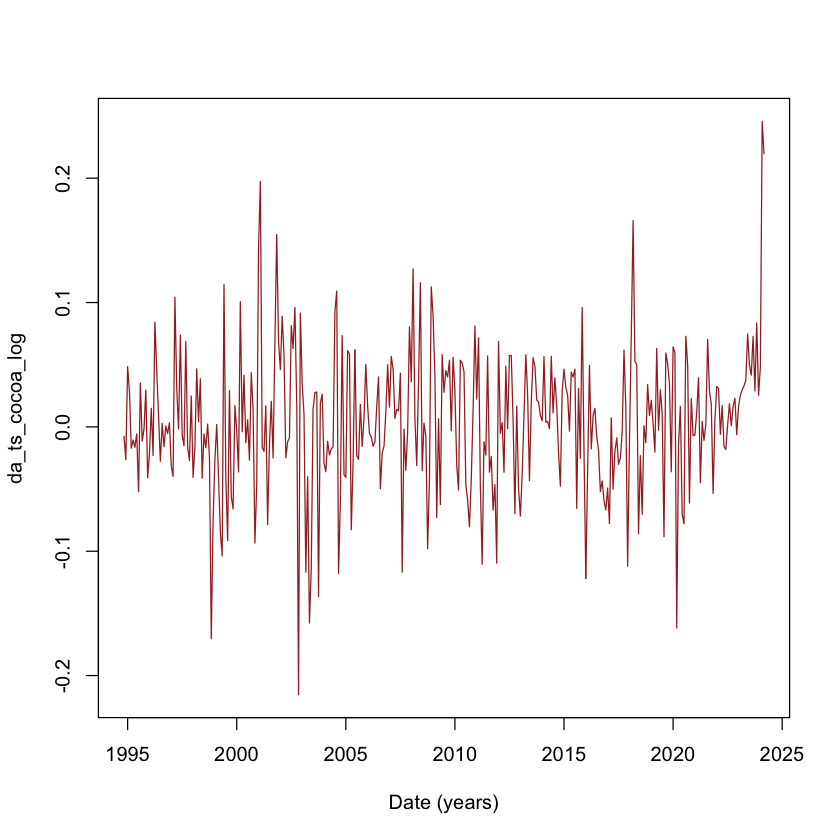

In [116]:
da_ts_cocoa_log <- diff(ts_cocoa_log)
plot(da_ts_cocoa_log, col='brown', xlab='Date (years)')

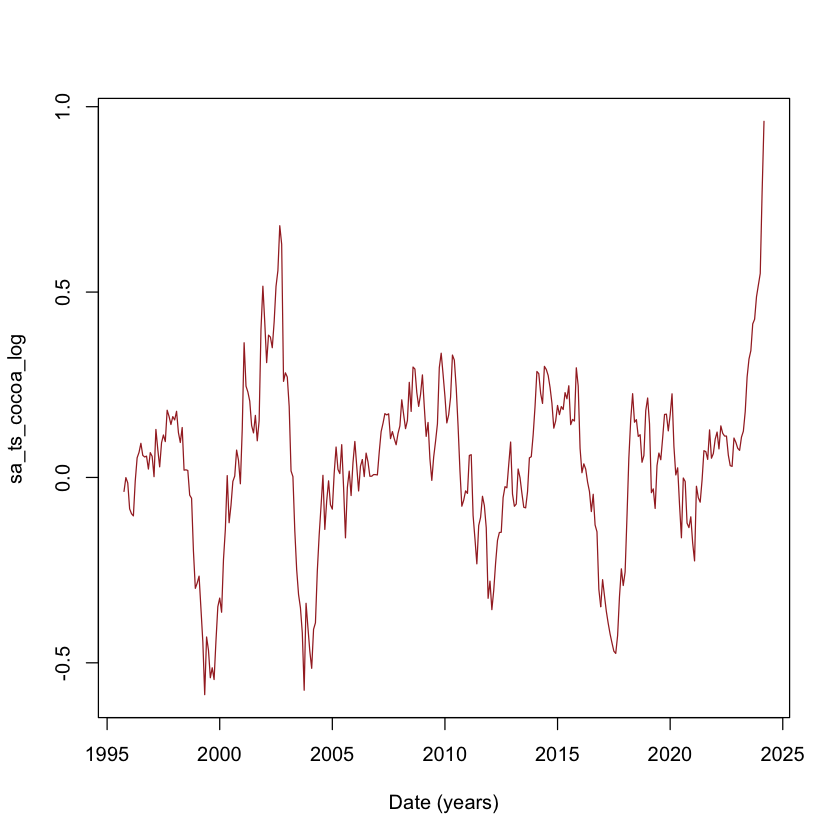

In [117]:
sa_ts_cocoa_log <- diff(ts_cocoa_log, lag=12)
plot(sa_ts_cocoa_log, col='brown', xlab='Date (years)')

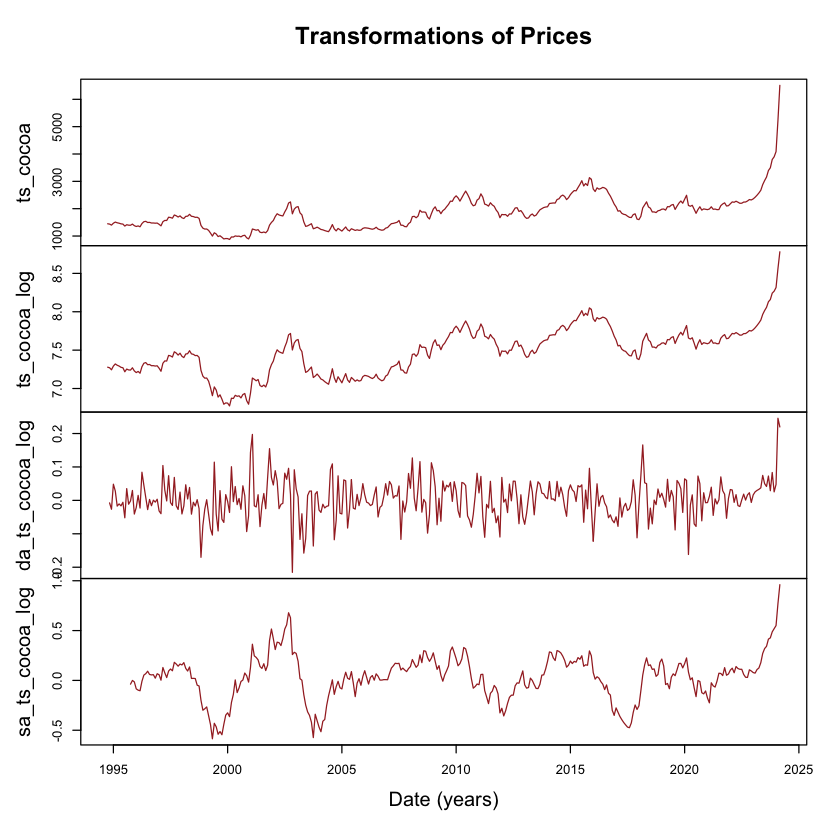

In [118]:
plot(cbind(ts_cocoa, ts_cocoa_log, da_ts_cocoa_log, sa_ts_cocoa_log), main = "Transformations of Prices", col='brown', xlab='Date (years)')

# ACF Plots

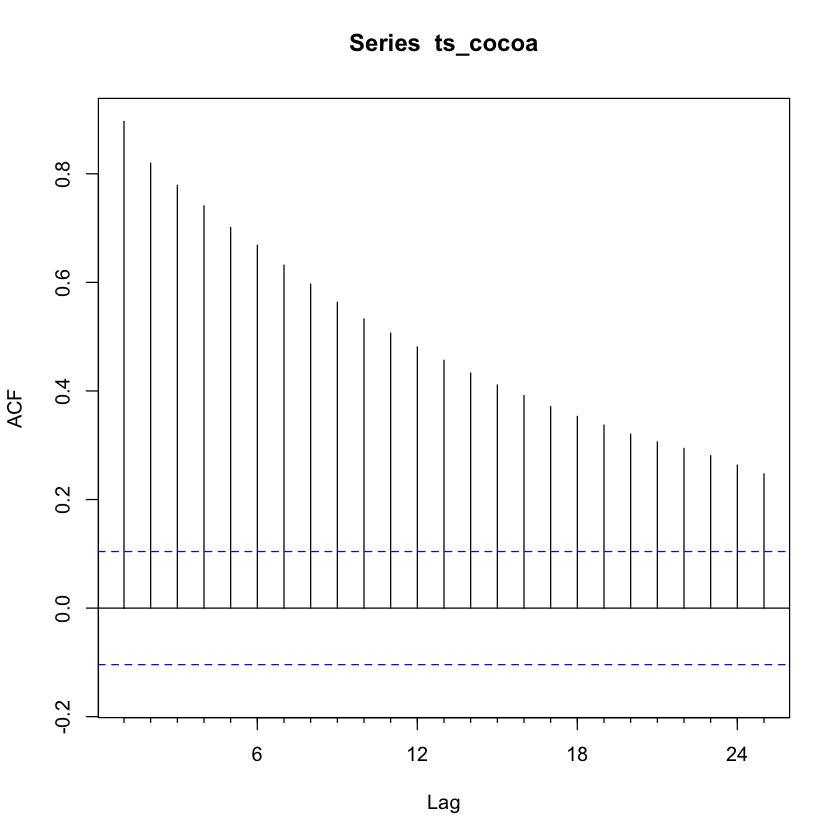

In [119]:
Acf(ts_cocoa)

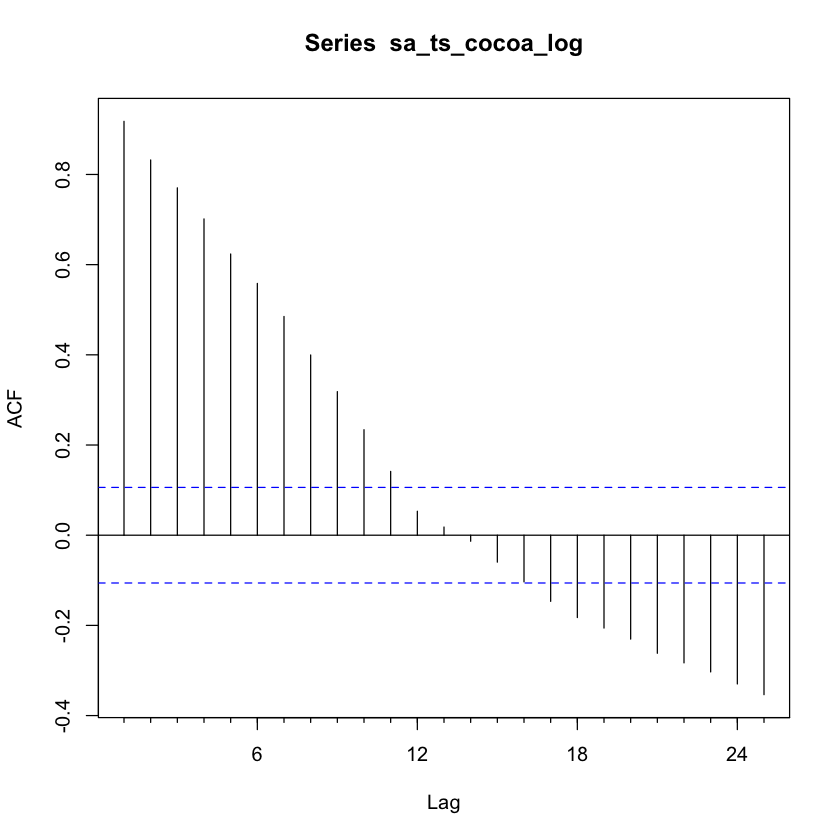

In [120]:
Acf(sa_ts_cocoa_log)

# PACF Plot

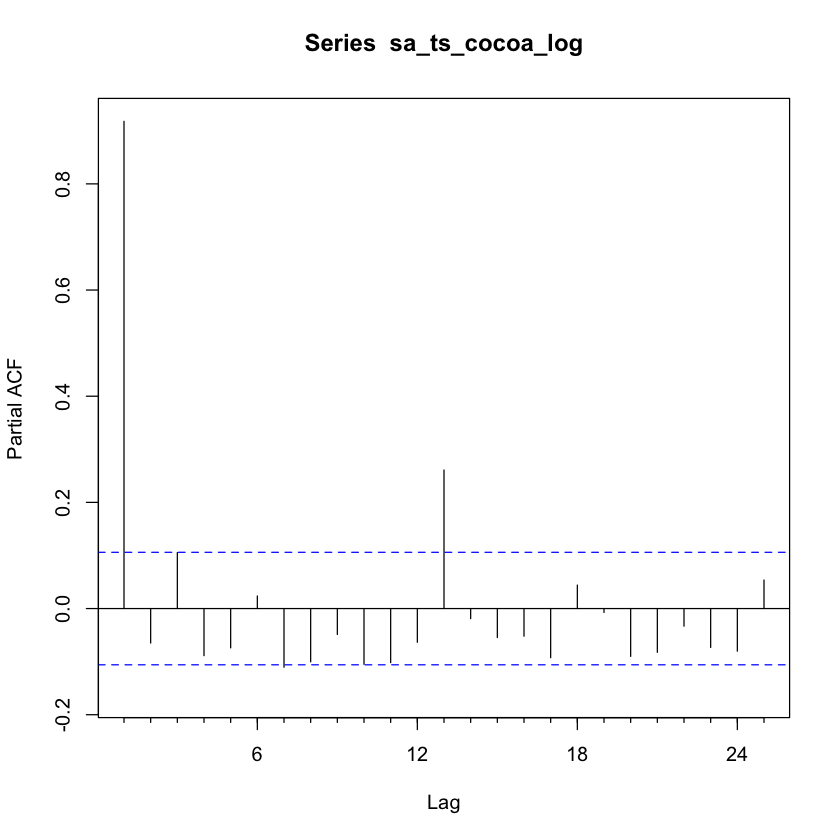

In [121]:
Pacf(sa_ts_cocoa_log)

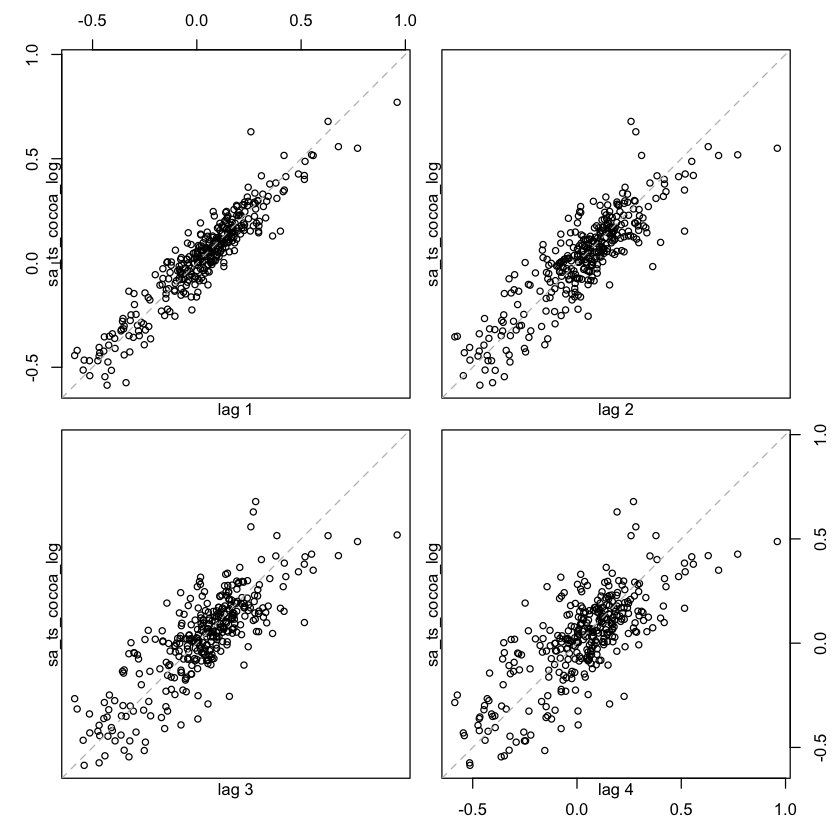

In [122]:
lag.plot(sa_ts_cocoa_log, lags=4)

In [123]:
fitauto <- auto.arima(sa_ts_cocoa_log)
fitauto

Series: sa_ts_cocoa_log 
ARIMA(4,0,1)(2,0,0)[12] with non-zero mean 

Coefficients:
         ar1      ar2     ar3      ar4      ma1     sar1     sar2    mean
      2.0383  -1.2780  0.3796  -0.1481  -0.9013  -0.6453  -0.3028  0.0344
s.e.  0.0695   0.1315  0.1236   0.0582   0.0480   0.0538   0.0533  0.0225

sigma^2 = 0.003946:  log likelihood = 460.84
AIC=-903.67   AICc=-903.13   BIC=-869.16

In [124]:
fit1 <- arima(sa_ts_cocoa_log, order=c(3,0,0))
fit1


Call:
arima(x = sa_ts_cocoa_log, order = c(3, 0, 0))

Coefficients:
         ar1      ar2     ar3  intercept
      1.1114  -0.2542  0.1000     0.0801
s.e.  0.0542   0.0800  0.0553     0.0929

sigma^2 estimated as 0.00575:  log likelihood = 395.53,  aic = -781.06

In [125]:
fit2 <- arima(sa_ts_cocoa_log, order=c(1,0,3))
fit2


Call:
arima(x = sa_ts_cocoa_log, order = c(1, 0, 3))

Coefficients:
         ar1     ma1      ma2     ma3  intercept
      0.9465  0.1616  -0.0646  0.0499     0.0748
s.e.  0.0231  0.0594   0.0547  0.0601     0.0852

sigma^2 estimated as 0.00572:  log likelihood = 396.43,  aic = -780.86

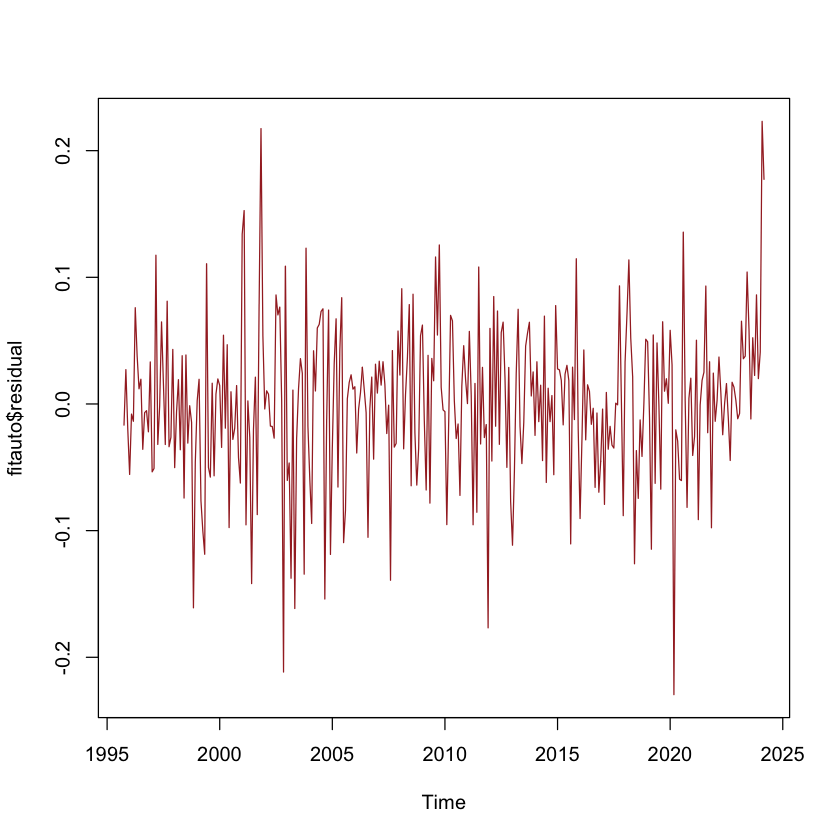

In [126]:
plot(fitauto$residual, col='brown')

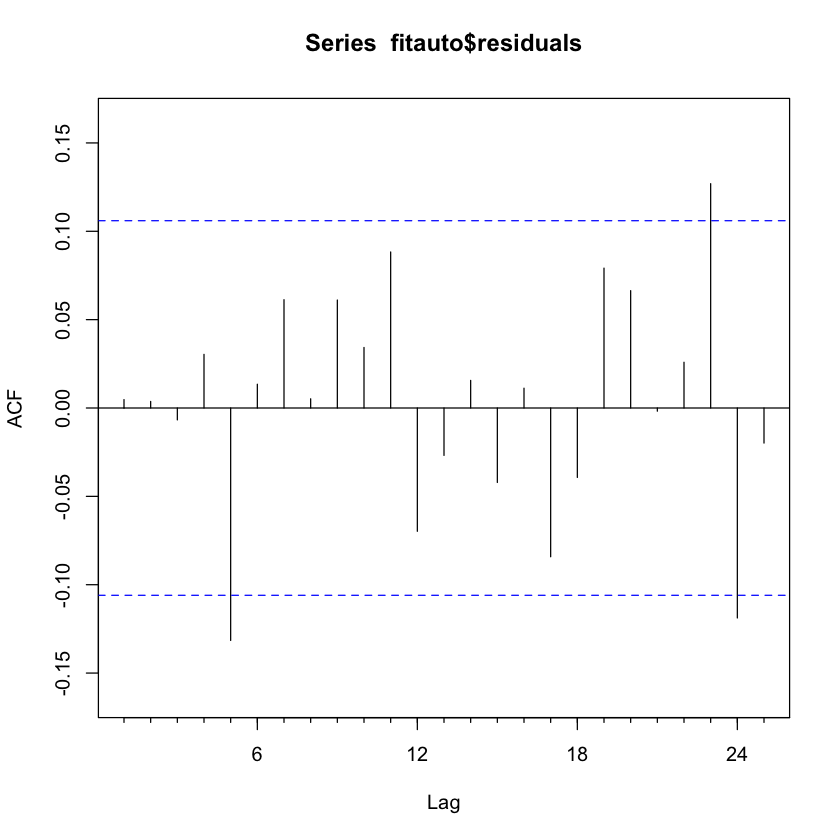

In [127]:
Acf(fitauto$residuals)

In [128]:
Box.test(fitauto$residual, type='Ljung')


	Box-Ljung test

data:  fitauto$residual
X-squared = 0.0077989, df = 1, p-value = 0.9296


In [129]:
library(fpp2)
library(aTSA)

-- Attaching packages ---------------------------------------------- fpp2 2.5 --

v fma       2.5     v expsmooth 2.3






Attaching package: 'aTSA'


The following object is masked from 'package:forecast':

    forecast


The following object is masked from 'package:graphics':

    identify




In [130]:
adf.test(ts_cocoa)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag  ADF p.value
[1,]   0 3.50   0.990
[2,]   1 2.20   0.990
[3,]   2 2.27   0.990
[4,]   3 2.04   0.990
[5,]   4 1.80   0.982
[6,]   5 1.77   0.981
Type 2: with drift no trend 
     lag  ADF p.value
[1,]   0 5.44    0.99
[2,]   1 3.01    0.99
[3,]   2 3.17    0.99
[4,]   3 2.86    0.99
[5,]   4 2.45    0.99
[6,]   5 2.38    0.99
Type 3: with drift and trend 
     lag  ADF p.value
[1,]   0 4.64    0.99
[2,]   1 2.11    0.99
[3,]   2 2.31    0.99
[4,]   3 1.94    0.99
[5,]   4 1.50    0.99
[6,]   5 1.45    0.99
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [131]:
diff_ts_cocoa <- diff(ts_cocoa)

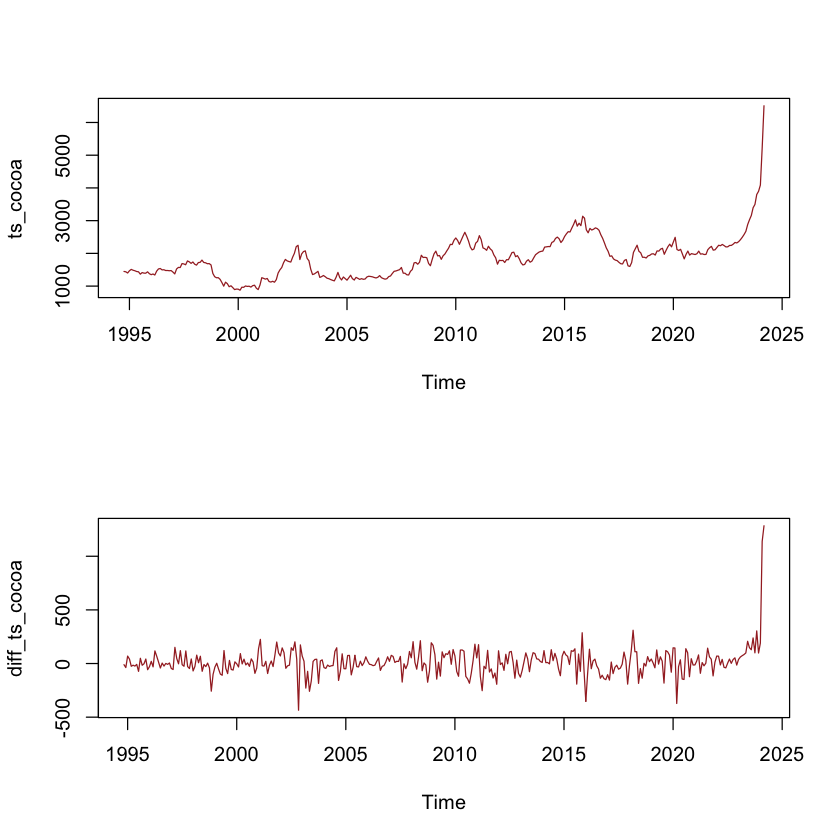

In [132]:
par(mfrow=c(2,1))
plot(ts_cocoa, col='brown')
plot(diff_ts_cocoa, col='brown')

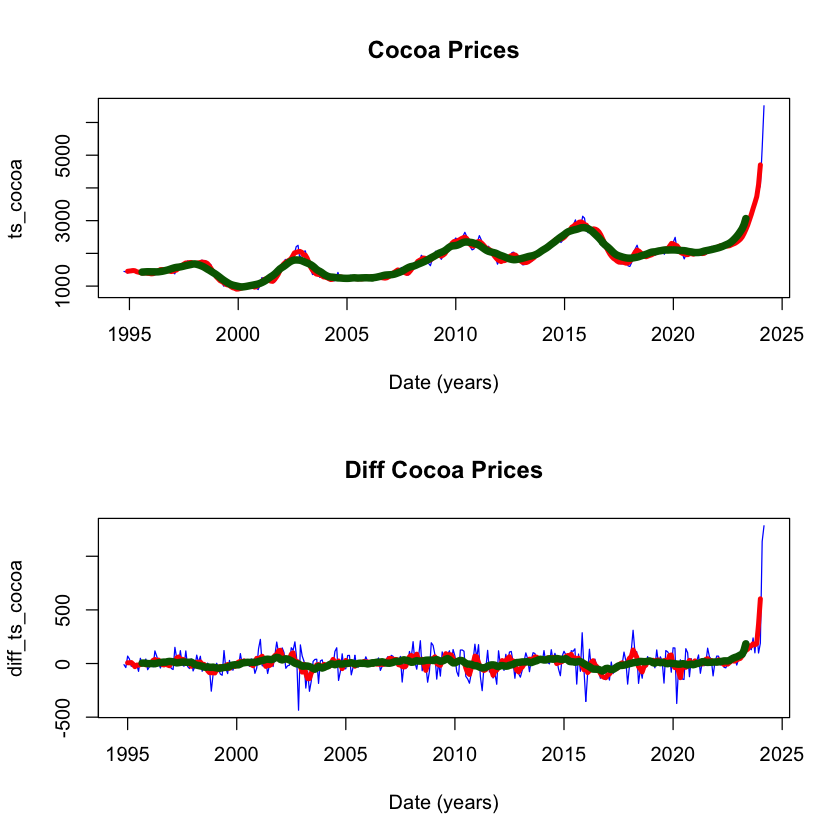

In [133]:
par(mfrow=c(2,1))

plot(ts_cocoa, col='blue', main='Cocoa Prices', xlab='Date (years)')
x <- as.vector(time(ts_cocoa))
y <- ma(ts_cocoa, order=5)
lines(x, y, col='red', lw=4)
y <- ma(ts_cocoa, order=20)
lines(x, y, col='darkgreen', lw=6)


plot(diff_ts_cocoa, col='blue', main='Diff Cocoa Prices', xlab='Date (years)')
x <- as.vector(time(diff_ts_cocoa))
y <- ma(diff_ts_cocoa, order=5)
lines(x, y, col='red', lw=4)
y <- ma(diff_ts_cocoa, order=20)
lines(x, y, col='darkgreen', lw=6)

In [134]:
adf.test(diff_ts_cocoa)

Augmented Dickey-Fuller Test 
alternative: stationary 
 
Type 1: no drift no trend 
     lag    ADF p.value
[1,]   0 -9.141   0.010
[2,]   1 -6.843   0.010
[3,]   2 -4.466   0.010
[4,]   3 -2.753   0.010
[5,]   4 -2.201   0.028
[6,]   5 -0.544   0.484
Type 2: with drift no trend 
     lag    ADF p.value
[1,]   0 -9.244  0.0100
[2,]   1 -6.968  0.0100
[3,]   2 -4.595  0.0100
[4,]   3 -2.885  0.0491
[5,]   4 -2.341  0.1928
[6,]   5 -0.685  0.8097
Type 3: with drift and trend 
     lag    ADF p.value
[1,]   0 -9.486  0.0100
[2,]   1 -7.233  0.0100
[3,]   2 -4.881  0.0100
[4,]   3 -3.178  0.0918
[5,]   4 -2.638  0.3073
[6,]   5 -0.983  0.9405
---- 
Note: in fact, p.value = 0.01 means p.value <= 0.01 


In [135]:
plot.acf.pacf <- function(ts)
{ layout(mat = matrix(c(1,1,2,3), 
                      nrow=2, ncol=2, byrow=TRUE))
  plot(ts)
  Acf(ts, main='ACF')
  Pacf(ts, main='PACF')
}

Choosing Model Parameters

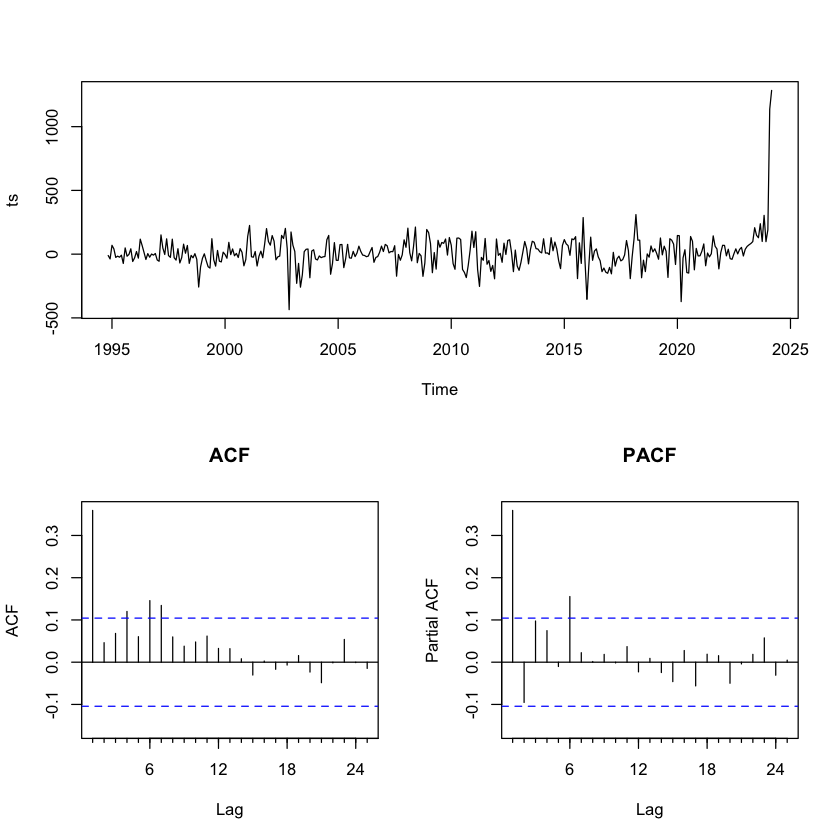

In [136]:
plot.acf.pacf(diff_ts_cocoa)

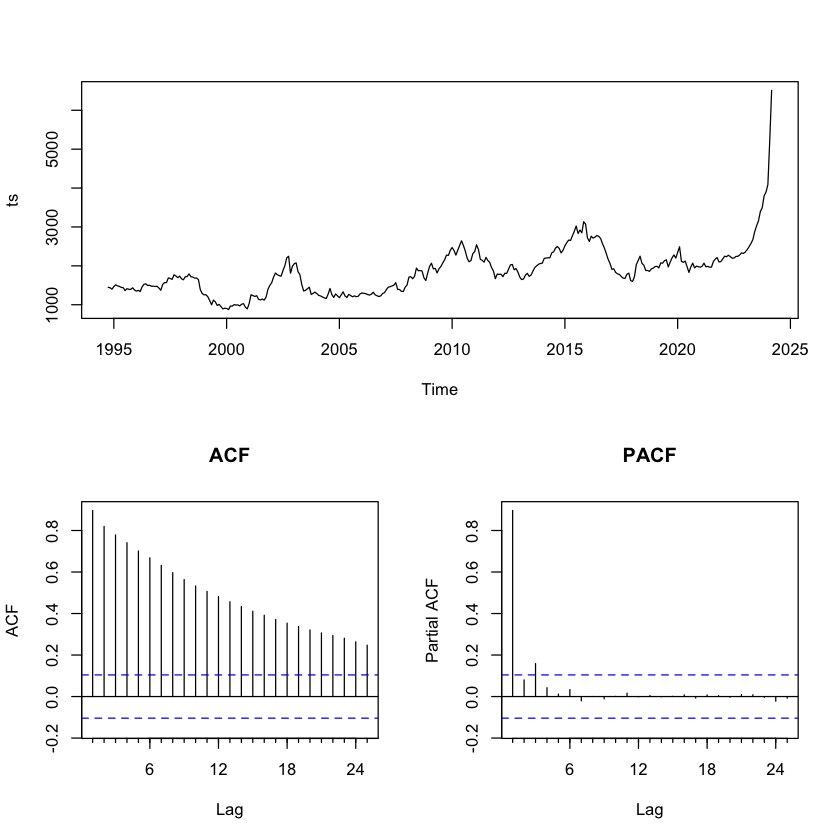

In [137]:
plot.acf.pacf(ts_cocoa)

In [138]:
a111 <- arima(ts_cocoa, order=c(1,1,1))
a111


Call:
arima(x = ts_cocoa, order = c(1, 1, 1))

Coefficients:
         ar1     ma1
      0.3892  0.1058
s.e.  0.1623  0.1614

sigma^2 estimated as 15101:  log likelihood = -2199.39,  aic = 4404.77

Forecast for univariate time series: 
    Lead Forecast S.E Lower Upper
355    1     7087 123  6846  7328
------ 
Note: confidence level = 95 % 


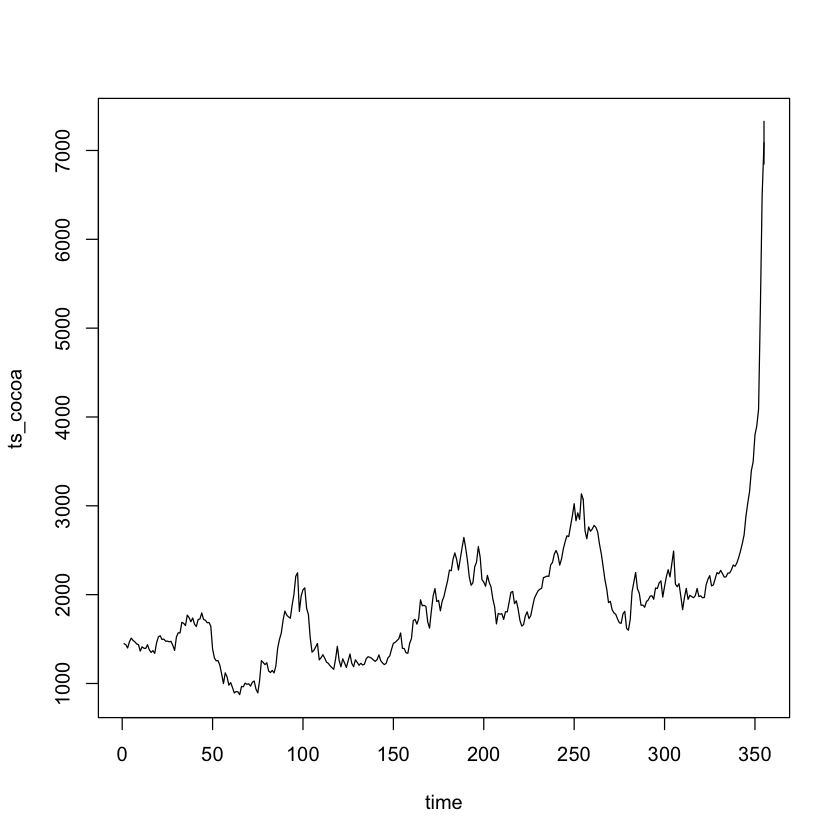

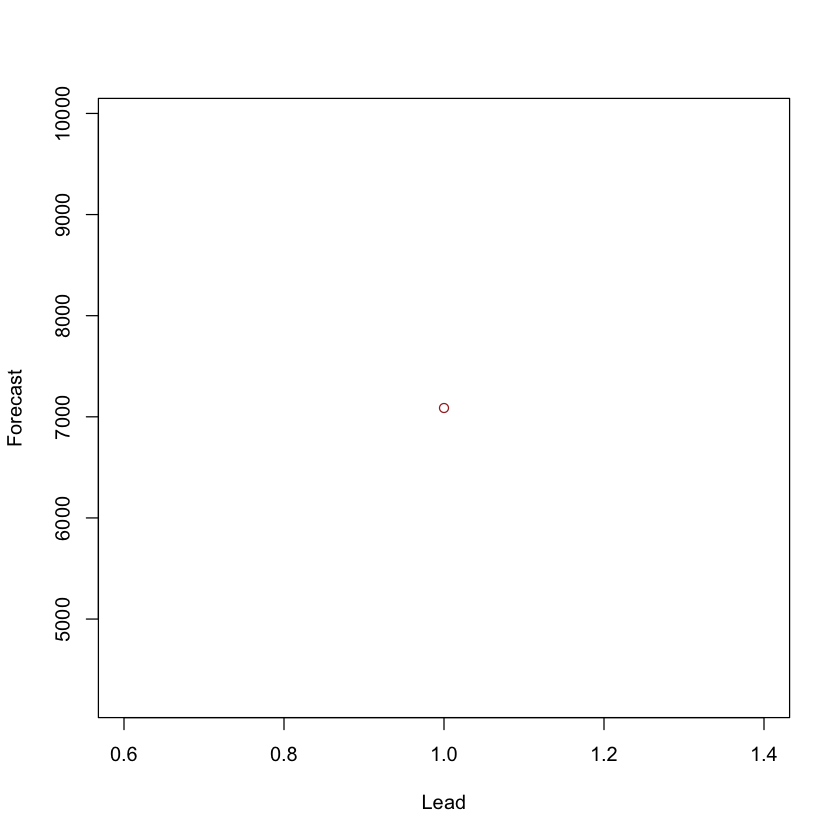

In [139]:
plot(forecast(a111), col='brown')

In [140]:
am <- auto.arima(diff_ts_cocoa)
am

Series: diff_ts_cocoa 
ARIMA(0,1,2) 

Coefficients:
          ma1      ma2
      -0.5353  -0.2611
s.e.   0.0530   0.0545

sigma^2 = 14545:  log likelihood = -2185.86
AIC=4377.72   AICc=4377.79   BIC=4389.32

In [141]:
a210 <- arima(diff_ts_cocoa, order=c(2,1,0))
a210


Call:
arima(x = diff_ts_cocoa, order = c(2, 1, 0))

Coefficients:
          ar1      ar2
      -0.3854  -0.3037
s.e.   0.0520   0.0559

sigma^2 estimated as 15844:  log likelihood = -2201.63,  aic = 4409.25

In [142]:
test <- diff(test)

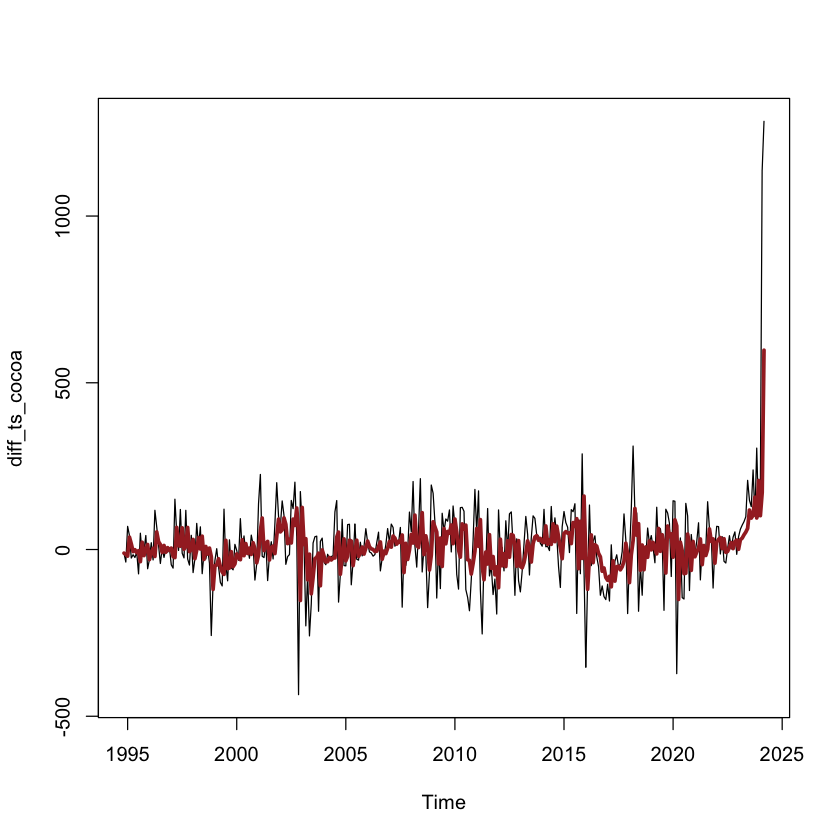

In [143]:
plot(diff_ts_cocoa)
x <- as.vector(time(diff_ts_cocoa))
y <- fitted(am)
lines(x, y, col='brown', lw=3)

RESIDUALS

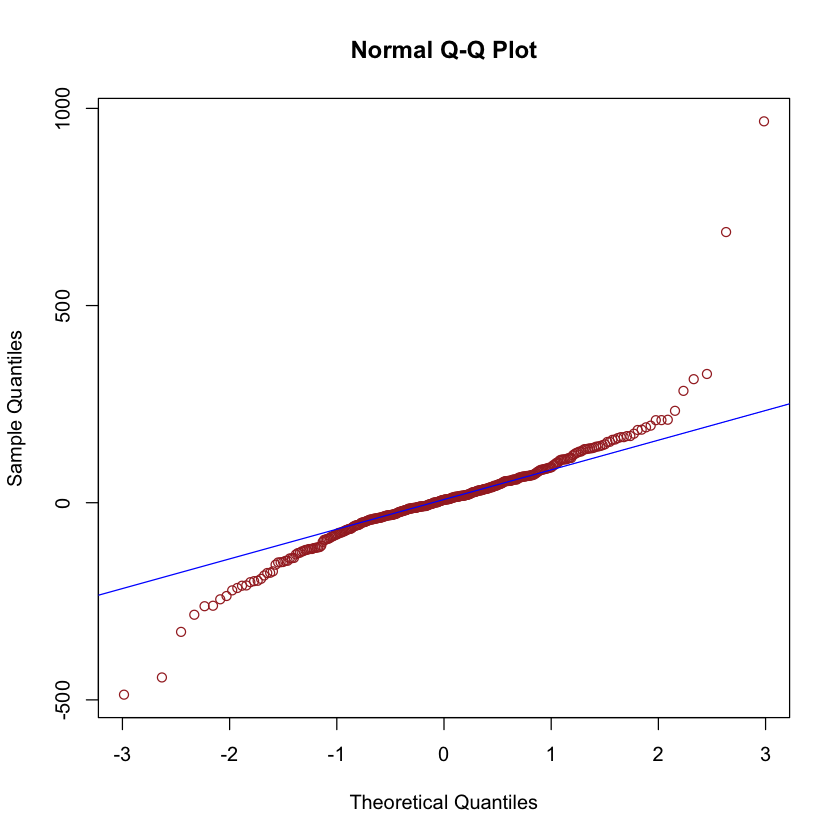

In [154]:
qqnorm(am$residuals, col='brown')
qqline(am$residuals, col='blue')

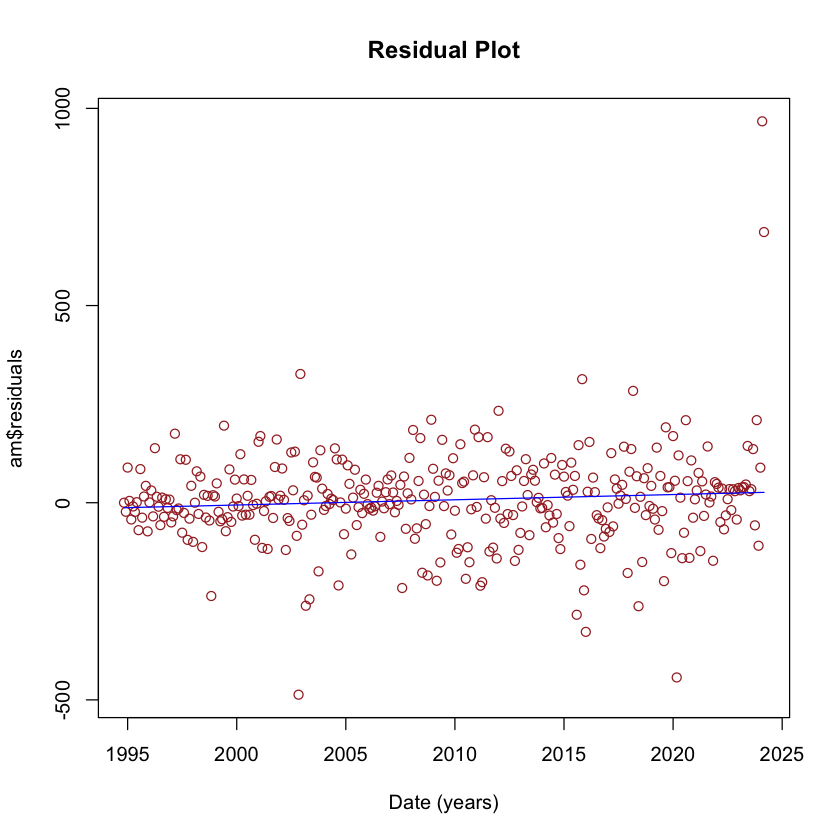

In [145]:
plot(am$residuals, type='p', main='Residual Plot', col='brown', xlab='Date (years)')
rlm <- lm(am$residuals ~ time(diff_ts_cocoa))
x <- as.vector(time(diff_ts_cocoa))
y <- rlm$fitted
lines(x, y, col='blue')

In [146]:
Box.test(am$residuals, type='Ljung')


	Box-Ljung test

data:  am$residuals
X-squared = 0.022225, df = 1, p-value = 0.8815


FORECASTING

In [147]:
tail(round(fitted(am)),6)

Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
2023                                     157  95 207
2024 102 171 598

In [148]:
round(accuracy(tail(round(fitted(am)),6), test),4)

ME      RMSE     MAE    MPE     MAPE    ACF1   Theil's U
Test set 368.426 542.2786 412.07 28.4333 73.0181 0.2935 1.0183

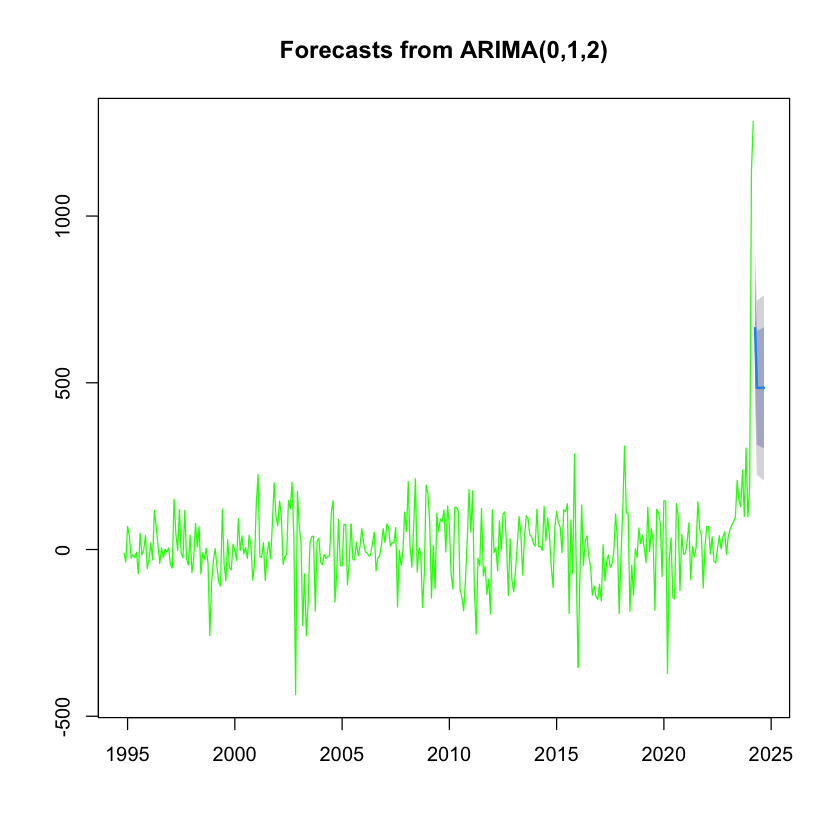

In [149]:
plot(forecast::forecast(am, 6), col='green')

# x <- as.vector(seq(1,354))
# y <- diff_ts_cocoa

# lines(x, y, col='blue', lw=4)
# y <- fitted(am)
# lines(x, y, col='red', lw=4)

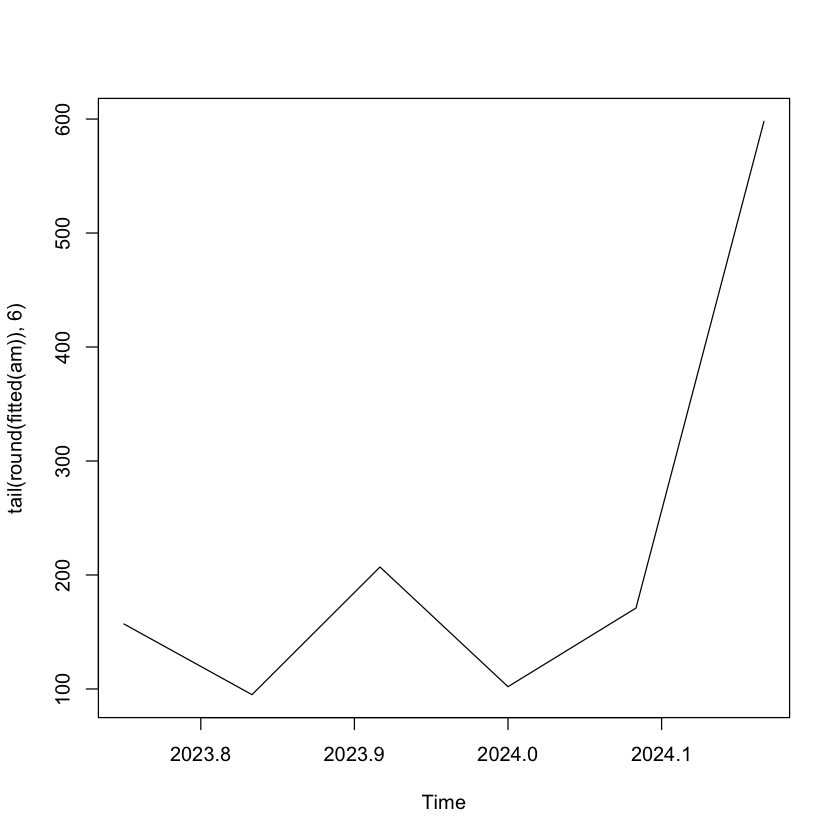

In [150]:
plot(tail(round(fitted(am)),6))

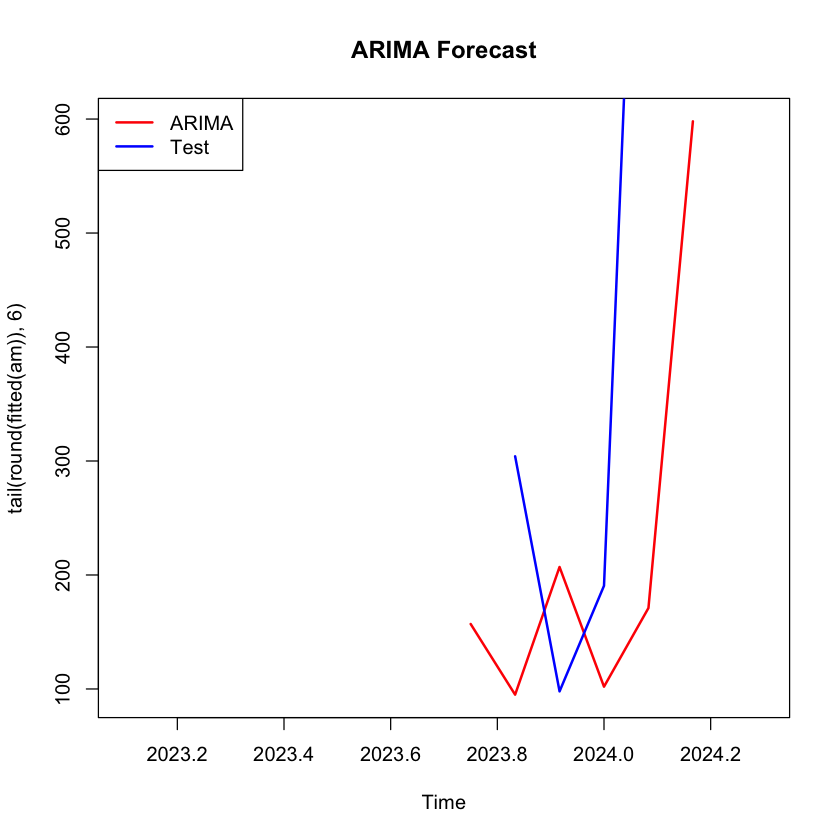

In [151]:

plot(tail(round(fitted(am)),6), xlim=c(2023.10,2024.3), main='ARIMA Forecast', lwd = 2, col='red')
x <- as.vector(time(test))
y <- test
lines(x, y, col='blue', lwd=2)
legend('topleft', legend = c('ARIMA', 'Test'), col = c('red', 'blue'), lwd = 2)